<a href="https://colab.research.google.com/github/abdul120866/ML-Based-Breast-Tissue-Classification/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O gene_exp.diff.zip "https://figshare.com/ndownloader/articles/7379186/versions/3"
!unzip gene_exp.diff.zip

--2025-05-03 15:49:10--  https://figshare.com/ndownloader/articles/7379186/versions/3
Resolving figshare.com (figshare.com)... 52.49.76.148, 54.195.113.107, 34.241.90.58, ...
Connecting to figshare.com (figshare.com)|52.49.76.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1034978309 (987M) [application/zip]
Saving to: ‘gene_exp.diff.zip’

gene_exp.diff.zip   100%[===================>] 987.03M  73.6MB/s    in 13s     

2025-05-03 15:49:24 (75.8 MB/s) - ‘gene_exp.diff.zip’ saved [1034978309/1034978309]

Archive:  gene_exp.diff.zip
 extracting: original.png            
 extracting: annotated.png           
 extracting: annotation_details.xlsx  
 extracting: data.json               
 extracting: BreCaHAD.zip            


In [ ]:
!unzip BreCaHAD.zip

Archive:  BreCaHAD.zip
  inflating: LICENSE                 
  inflating: README.md               
   creating: images/
  inflating: images/Case_1-01.tif    
  inflating: images/Case_1-02.tif    
  inflating: images/Case_1-03.tif    
  inflating: images/Case_1-04.tif    
  inflating: images/Case_1-05.tif    
  inflating: images/Case_1-06.tif    
  inflating: images/Case_1-07.tif    
  inflating: images/Case_1-08.tif    
  inflating: images/Case_10-01.tif   
  inflating: images/Case_10-02.tif   
  inflating: images/Case_10-03.tif   
  inflating: images/Case_10-04.tif   
  inflating: images/Case_10-05.tif   
  inflating: images/Case_10-06.tif   
  inflating: images/Case_10-07.tif   
  inflating: images/Case_10-08.tif   
  inflating: images/Case_10-09.tif   
  inflating: images/Case_10-10.tif   
  inflating: images/Case_11-07.tif   
  inflating: images/Case_11-09.tif   
  inflating: images/Case_11-10.tif   
  inflating: images/Case_11-11.tif   
  inflating: images/Case_11-12.tif   
  infl

In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
image_dir = "images"
anno_dir = "groundTruth"



# Accept multiple image formats
image_extensions = (".png", ".jpg", ".jpeg", ".tif", ".tiff")

image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(image_extensions)])
json_files = sorted([f for f in os.listdir(anno_dir) if f.endswith(".json")])

print(f"✅ Found {len(image_files)} image(s)")
print(f"✅ Found {len(json_files)} annotation(s)")

print("\nSample image filenames:", image_files[:3])
print("Sample annotation filenames:", json_files[:3])


✅ Found 162 image(s)
✅ Found 162 annotation(s)

Sample image filenames: ['Case_1-01.tif', 'Case_1-02.tif', 'Case_1-03.tif']
Sample annotation filenames: ['Case_1-01.json', 'Case_1-02.json', 'Case_1-03.json']


In [ ]:
import json

# Pick one annotation to inspect
sample_json = os.path.join(anno_dir, "Case_1-01.json")

with open(sample_json, 'r') as f:
    data = json.load(f)

print(json.dumps(data, indent=2))


{
  "mitosis": [],
  "non_mitosis": [],
  "apoptosis": [
    {
      "x": 0.7369207039192316,
      "y": 0.8462455303933254
    }
  ],
  "tumor": [
    {
      "x": 0.08808104886769964,
      "y": 0.30274135876042907
    },
    {
      "x": 0.053978826333870855,
      "y": 0.2598331346841478
    },
    {
      "x": 0.08718362195891467,
      "y": 0.2359952324195471
    },
    {
      "x": 0.05218397251630092,
      "y": 0.22526817640047675
    },
    {
      "x": 0.05667110706022576,
      "y": 0.3456495828367104
    },
    {
      "x": 0.14192666339479773,
      "y": 0.29916567342073896
    },
    {
      "x": 0.14461894412115264,
      "y": 0.3230035756853397
    },
    {
      "x": 0.12397812521909837,
      "y": 0.2526817640047676
    },
    {
      "x": 0.08808104886769964,
      "y": 0.041716328963051254
    },
    {
      "x": 0.0638505223305055,
      "y": 0.03933253873659118
    },
    {
      "x": 0.04769683797237608,
      "y": 0.0631704410011919
    },
    {
      "x": 0.10

In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# === Define Directories ===
image_dir = "images"           # Update if path differs
anno_dir = "groundTruth"       # Update if path differs

# === Supported Image Formats ===
image_extensions = (".png", ".jpg", ".jpeg", ".tif", ".tiff")

# === Label Mapping Based on JSON Keys ===
label_mapping = {
    "mitosis": "mitosis",
    "apoptosis": "apoptosis",
    "tumor": "tumor",
    "non_tumor": "non_tumor",
    "lumen": "tubule",
    "non_lumen": "non_tubule"
}

# === Function: Match Image with JSON ===
def match_json_file(image_name):
    base = os.path.splitext(image_name)[0]
    return base + ".json"

# === Function: Extract ROIs from Image + JSON ===
def extract_rois_from_file(image_path, json_path, patch_size=64, debug=False, show_limit=3):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"[❌ ERROR] Could not load image: {image_path}")
            return [], [], 0, 0

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h, w = img.shape

        with open(json_path, 'r') as f:
            annotations = json.load(f)

        patches = []
        labels = []
        total_ann = 0
        skipped = 0
        shown = 0

        for label, points in annotations.items():
            mapped_label = label_mapping.get(label, None)
            if not mapped_label or not points:
                continue

            for ann in points:
                total_ann += 1
                x = int(ann['x'] * w)
                y = int(ann['y'] * h)

                x1 = max(0, x - patch_size // 2)
                y1 = max(0, y - patch_size // 2)
                x2 = min(w, x + patch_size // 2)
                y2 = min(h, y + patch_size // 2)

                patch = img[y1:y2, x1:x2]
                if patch.shape != (patch_size, patch_size):
                    skipped += 1
                    continue

                patches.append(patch)
                labels.append(mapped_label)

                if debug and shown < show_limit:
                    print(f"[🟢 PATCH] {mapped_label} at ({x}, {y})")
                    plt.imshow(patch, cmap='gray')
                    plt.title(f"{mapped_label} @ ({x},{y})")
                    plt.axis('off')
                    plt.show()
                    shown += 1

        return patches, labels, total_ann, skipped

    except Exception as e:
        print(f"[ERROR] Exception while processing {image_path}: {e}")
        return [], [], 0, 0


# === Step 1: Discover All Image/JSON Files ===
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(image_extensions)])
json_files = sorted([f for f in os.listdir(anno_dir) if f.endswith(".json")])

print(f"✅ Found {len(image_files)} image(s)")
print(f"✅ Found {len(json_files)} annotation(s)")

# === Step 2: Extract All ROIs ===
all_patches = []
all_labels = []

total_annotations_all = 0
skipped_patches_all = 0

for img_name in tqdm(image_files):
    json_name = match_json_file(img_name)
    img_path = os.path.join(image_dir, img_name)
    json_path = os.path.join(anno_dir, json_name)

    if not os.path.exists(json_path):
        print(f"[⚠️ Missing] Annotation for {img_name}")
        continue

    patches, labels, total_ann, skipped = extract_rois_from_file(img_path, json_path, patch_size=64, debug=False)

    total_annotations_all += total_ann
    skipped_patches_all += skipped

    print(f"📂 {img_name} → Annotations: {total_ann}, Skipped: {skipped}, Extracted: {len(patches)}")

    all_patches.extend(patches)
    all_labels.extend(labels)

# Final summary
print("\n✅ Total Annotations Attempted:", total_annotations_all)
print("❌ Total Patches Skipped:", skipped_patches_all)
print("✅ Total Valid ROIs Extracted:", len(all_patches))


✅ Found 162 image(s)
✅ Found 162 annotation(s)


  1%|          | 2/162 [00:00<00:27,  5.90it/s]

📂 Case_1-01.tif → Annotations: 146, Skipped: 3, Extracted: 143
📂 Case_1-02.tif → Annotations: 177, Skipped: 11, Extracted: 166


  2%|▏         | 4/162 [00:00<00:23,  6.66it/s]

📂 Case_1-03.tif → Annotations: 160, Skipped: 5, Extracted: 155
📂 Case_1-04.tif → Annotations: 123, Skipped: 4, Extracted: 119


  4%|▎         | 6/162 [00:00<00:22,  6.93it/s]

📂 Case_1-05.tif → Annotations: 143, Skipped: 5, Extracted: 138
📂 Case_1-06.tif → Annotations: 208, Skipped: 8, Extracted: 200


  5%|▍         | 8/162 [00:01<00:21,  7.09it/s]

📂 Case_1-07.tif → Annotations: 229, Skipped: 2, Extracted: 227
📂 Case_1-08.tif → Annotations: 125, Skipped: 2, Extracted: 123
📂 Case_10-01.tif → Annotations: 198, Skipped: 13, Extracted: 185


  9%|▊         | 14/162 [00:01<00:09, 15.19it/s]

📂 Case_10-02.tif → Annotations: 184, Skipped: 4, Extracted: 180
📂 Case_10-03.tif → Annotations: 149, Skipped: 4, Extracted: 145
📂 Case_10-04.tif → Annotations: 140, Skipped: 2, Extracted: 138
📂 Case_10-05.tif → Annotations: 186, Skipped: 4, Extracted: 182
📂 Case_10-06.tif → Annotations: 161, Skipped: 3, Extracted: 158
📂 Case_10-07.tif → Annotations: 252, Skipped: 5, Extracted: 247


 14%|█▎        | 22/162 [00:01<00:05, 24.00it/s]

📂 Case_10-08.tif → Annotations: 163, Skipped: 2, Extracted: 161
📂 Case_10-09.tif → Annotations: 116, Skipped: 4, Extracted: 112
📂 Case_10-10.tif → Annotations: 151, Skipped: 3, Extracted: 148
📂 Case_11-07.tif → Annotations: 42, Skipped: 0, Extracted: 42
📂 Case_11-09.tif → Annotations: 38, Skipped: 0, Extracted: 38
📂 Case_11-10.tif → Annotations: 91, Skipped: 0, Extracted: 91
📂 Case_11-11.tif → Annotations: 79, Skipped: 2, Extracted: 77


 19%|█▊        | 30/162 [00:01<00:04, 29.80it/s]

📂 Case_11-12.tif → Annotations: 85, Skipped: 3, Extracted: 82
📂 Case_11-13.tif → Annotations: 75, Skipped: 0, Extracted: 75
📂 Case_11-15.tif → Annotations: 51, Skipped: 2, Extracted: 49
📂 Case_12-01.tif → Annotations: 131, Skipped: 5, Extracted: 126
📂 Case_12-02.tif → Annotations: 133, Skipped: 5, Extracted: 128
📂 Case_12-03.tif → Annotations: 170, Skipped: 4, Extracted: 166
📂 Case_12-04.tif → Annotations: 137, Skipped: 1, Extracted: 136
📂 Case_12-05.tif → Annotations: 141, Skipped: 7, Extracted: 134


 23%|██▎       | 38/162 [00:02<00:03, 32.57it/s]

📂 Case_12-06.tif → Annotations: 124, Skipped: 12, Extracted: 112
📂 Case_12-07.tif → Annotations: 124, Skipped: 12, Extracted: 112
📂 Case_12-08.tif → Annotations: 202, Skipped: 4, Extracted: 198
📂 Case_12-09.tif → Annotations: 168, Skipped: 5, Extracted: 163
📂 Case_12-10.tif → Annotations: 173, Skipped: 7, Extracted: 166
📂 Case_12-11.tif → Annotations: 103, Skipped: 2, Extracted: 101
📂 Case_12-12.tif → Annotations: 124, Skipped: 5, Extracted: 119
📂 Case_13-01.tif → Annotations: 153, Skipped: 7, Extracted: 146


 28%|██▊       | 46/162 [00:02<00:03, 34.01it/s]

📂 Case_13-02.tif → Annotations: 120, Skipped: 5, Extracted: 115
📂 Case_13-03.tif → Annotations: 148, Skipped: 10, Extracted: 138
📂 Case_13-04.tif → Annotations: 134, Skipped: 4, Extracted: 130
📂 Case_13-05.tif → Annotations: 116, Skipped: 8, Extracted: 108
📂 Case_13-06.tif → Annotations: 155, Skipped: 3, Extracted: 152
📂 Case_13-07.tif → Annotations: 140, Skipped: 3, Extracted: 137
📂 Case_13-10.tif → Annotations: 96, Skipped: 1, Extracted: 95
📂 Case_13-11.tif → Annotations: 124, Skipped: 1, Extracted: 123


 33%|███▎      | 54/162 [00:02<00:03, 34.19it/s]

📂 Case_13-12.tif → Annotations: 101, Skipped: 2, Extracted: 99
📂 Case_14-01.tif → Annotations: 111, Skipped: 3, Extracted: 108
📂 Case_14-02.tif → Annotations: 97, Skipped: 2, Extracted: 95
📂 Case_14-03.tif → Annotations: 102, Skipped: 3, Extracted: 99
📂 Case_14-04.tif → Annotations: 112, Skipped: 2, Extracted: 110
📂 Case_14-05.tif → Annotations: 119, Skipped: 5, Extracted: 114
📂 Case_14-06.tif → Annotations: 121, Skipped: 4, Extracted: 117
📂 Case_14-07.tif → Annotations: 75, Skipped: 2, Extracted: 73


 38%|███▊      | 62/162 [00:02<00:02, 34.40it/s]

📂 Case_14-08.tif → Annotations: 163, Skipped: 4, Extracted: 159
📂 Case_14-09.tif → Annotations: 152, Skipped: 1, Extracted: 151
📂 Case_14-10.tif → Annotations: 11, Skipped: 0, Extracted: 11
📂 Case_14-11.tif → Annotations: 5, Skipped: 0, Extracted: 5
📂 Case_14-12.tif → Annotations: 109, Skipped: 1, Extracted: 108
📂 Case_15-01.tif → Annotations: 142, Skipped: 4, Extracted: 138
📂 Case_15-02.tif → Annotations: 212, Skipped: 3, Extracted: 209
📂 Case_15-03.tif → Annotations: 217, Skipped: 7, Extracted: 210


 43%|████▎     | 70/162 [00:03<00:02, 35.14it/s]

📂 Case_15-04.tif → Annotations: 206, Skipped: 7, Extracted: 199
📂 Case_15-05.tif → Annotations: 160, Skipped: 2, Extracted: 158
📂 Case_15-06.tif → Annotations: 196, Skipped: 6, Extracted: 190
📂 Case_15-07.tif → Annotations: 209, Skipped: 7, Extracted: 202
📂 Case_15-08.tif → Annotations: 146, Skipped: 6, Extracted: 140
📂 Case_15-09.tif → Annotations: 277, Skipped: 5, Extracted: 272
📂 Case_15-10.tif → Annotations: 199, Skipped: 6, Extracted: 193
📂 Case_15-11.tif → Annotations: 335, Skipped: 8, Extracted: 327


 48%|████▊     | 78/162 [00:03<00:02, 35.78it/s]

📂 Case_15-12.tif → Annotations: 269, Skipped: 6, Extracted: 263
📂 Case_16-01.tif → Annotations: 148, Skipped: 8, Extracted: 140
📂 Case_16-02.tif → Annotations: 153, Skipped: 5, Extracted: 148
📂 Case_16-03.tif → Annotations: 123, Skipped: 2, Extracted: 121
📂 Case_16-04.tif → Annotations: 166, Skipped: 9, Extracted: 157
📂 Case_16-05.tif → Annotations: 193, Skipped: 10, Extracted: 183
📂 Case_16-06.tif → Annotations: 167, Skipped: 1, Extracted: 166
📂 Case_16-07.tif → Annotations: 162, Skipped: 0, Extracted: 162


 53%|█████▎    | 86/162 [00:03<00:02, 35.58it/s]

📂 Case_16-08.tif → Annotations: 172, Skipped: 5, Extracted: 167
📂 Case_16-09.tif → Annotations: 234, Skipped: 9, Extracted: 225
📂 Case_16-10.tif → Annotations: 214, Skipped: 2, Extracted: 212
📂 Case_16-11.tif → Annotations: 140, Skipped: 4, Extracted: 136
📂 Case_16-12.tif → Annotations: 113, Skipped: 3, Extracted: 110
📂 Case_16-13.tif → Annotations: 123, Skipped: 3, Extracted: 120
📂 Case_17-01.tif → Annotations: 123, Skipped: 7, Extracted: 116
📂 Case_17-02.tif → Annotations: 160, Skipped: 4, Extracted: 156


 56%|█████▌    | 90/162 [00:03<00:02, 35.21it/s]

📂 Case_17-03.tif → Annotations: 89, Skipped: 2, Extracted: 87
📂 Case_17-04.tif → Annotations: 141, Skipped: 7, Extracted: 134
📂 Case_17-05.tif → Annotations: 72, Skipped: 0, Extracted: 72
📂 Case_17-06.tif → Annotations: 125, Skipped: 0, Extracted: 125
📂 Case_17-07.tif → Annotations: 247, Skipped: 7, Extracted: 240
📂 Case_17-08.tif → Annotations: 194, Skipped: 5, Extracted: 189
📂 Case_17-09.tif → Annotations: 135, Skipped: 2, Extracted: 133


 58%|█████▊    | 94/162 [00:03<00:01, 34.21it/s]

📂 Case_17-10.tif → Annotations: 207, Skipped: 9, Extracted: 198
📂 Case_17-11.tif → Annotations: 128, Skipped: 3, Extracted: 125
📂 Case_17-12.tif → Annotations: 198, Skipped: 10, Extracted: 188
📂 Case_2-01.tif → Annotations: 136, Skipped: 5, Extracted: 131


 60%|██████    | 98/162 [00:03<00:02, 26.39it/s]

📂 Case_2-02.tif → Annotations: 184, Skipped: 4, Extracted: 180
📂 Case_2-03.tif → Annotations: 171, Skipped: 4, Extracted: 167
📂 Case_2-04.tif → Annotations: 151, Skipped: 8, Extracted: 143


 62%|██████▏   | 101/162 [00:04<00:03, 19.83it/s]

📂 Case_2-05.tif → Annotations: 120, Skipped: 2, Extracted: 118
📂 Case_2-06.tif → Annotations: 105, Skipped: 6, Extracted: 99
📂 Case_2-07.tif → Annotations: 131, Skipped: 3, Extracted: 128


 64%|██████▍   | 104/162 [00:04<00:03, 16.60it/s]

📂 Case_2-08.tif → Annotations: 181, Skipped: 7, Extracted: 174
📂 Case_3-01.tif → Annotations: 102, Skipped: 2, Extracted: 100
📂 Case_3-02.tif → Annotations: 137, Skipped: 4, Extracted: 133


 67%|██████▋   | 109/162 [00:04<00:03, 13.51it/s]

📂 Case_3-03.tif → Annotations: 81, Skipped: 1, Extracted: 80
📂 Case_3-04.tif → Annotations: 183, Skipped: 6, Extracted: 177
📂 Case_3-05.tif → Annotations: 151, Skipped: 2, Extracted: 149


 69%|██████▊   | 111/162 [00:05<00:03, 12.84it/s]

📂 Case_3-06.tif → Annotations: 203, Skipped: 1, Extracted: 202
📂 Case_3-07.tif → Annotations: 125, Skipped: 5, Extracted: 120
📂 Case_3-08.tif → Annotations: 235, Skipped: 8, Extracted: 227


 71%|███████   | 115/162 [00:05<00:03, 11.99it/s]

📂 Case_3-09.tif → Annotations: 112, Skipped: 1, Extracted: 111
📂 Case_3-10.tif → Annotations: 153, Skipped: 6, Extracted: 147
📂 Case_4-01.tif → Annotations: 166, Skipped: 5, Extracted: 161


 72%|███████▏  | 117/162 [00:05<00:03, 11.68it/s]

📂 Case_4-02.tif → Annotations: 123, Skipped: 5, Extracted: 118
📂 Case_4-03.tif → Annotations: 136, Skipped: 4, Extracted: 132
📂 Case_4-04.tif → Annotations: 128, Skipped: 7, Extracted: 121


 75%|███████▍  | 121/162 [00:06<00:03, 11.19it/s]

📂 Case_4-05.tif → Annotations: 126, Skipped: 3, Extracted: 123
📂 Case_4-06.tif → Annotations: 177, Skipped: 3, Extracted: 174
📂 Case_4-07.tif → Annotations: 138, Skipped: 3, Extracted: 135


 76%|███████▌  | 123/162 [00:06<00:03, 11.12it/s]

📂 Case_4-08.tif → Annotations: 71, Skipped: 0, Extracted: 71
📂 Case_4-09.tif → Annotations: 118, Skipped: 0, Extracted: 118
📂 Case_4-10.tif → Annotations: 97, Skipped: 1, Extracted: 96


 78%|███████▊  | 127/162 [00:06<00:03, 10.84it/s]

📂 Case_5-01.tif → Annotations: 187, Skipped: 3, Extracted: 184
📂 Case_5-02.tif → Annotations: 114, Skipped: 2, Extracted: 112
📂 Case_5-04.tif → Annotations: 152, Skipped: 3, Extracted: 149


 80%|███████▉  | 129/162 [00:06<00:03, 10.68it/s]

📂 Case_5-05.tif → Annotations: 203, Skipped: 2, Extracted: 201
📂 Case_5-07.tif → Annotations: 251, Skipped: 6, Extracted: 245
📂 Case_5-08.tif → Annotations: 229, Skipped: 10, Extracted: 219


 82%|████████▏ | 133/162 [00:07<00:02, 10.74it/s]

📂 Case_6-01.tif → Annotations: 197, Skipped: 4, Extracted: 193
📂 Case_6-02.tif → Annotations: 169, Skipped: 2, Extracted: 167
📂 Case_6-03.tif → Annotations: 114, Skipped: 1, Extracted: 113


 83%|████████▎ | 135/162 [00:07<00:02, 10.81it/s]

📂 Case_6-04.tif → Annotations: 147, Skipped: 3, Extracted: 144
📂 Case_6-05.tif → Annotations: 120, Skipped: 4, Extracted: 116
📂 Case_6-06.tif → Annotations: 98, Skipped: 1, Extracted: 97


 86%|████████▌ | 139/162 [00:07<00:02, 10.72it/s]

📂 Case_6-07.tif → Annotations: 112, Skipped: 3, Extracted: 109
📂 Case_6-08.tif → Annotations: 134, Skipped: 2, Extracted: 132
📂 Case_6-10.tif → Annotations: 129, Skipped: 3, Extracted: 126


 91%|█████████ | 147/162 [00:07<00:00, 20.56it/s]

📂 Case_7-01.tif → Annotations: 49, Skipped: 2, Extracted: 47
📂 Case_7-02.tif → Annotations: 54, Skipped: 0, Extracted: 54
📂 Case_7-03.tif → Annotations: 90, Skipped: 1, Extracted: 89
📂 Case_7-04.tif → Annotations: 112, Skipped: 7, Extracted: 105
📂 Case_7-05.tif → Annotations: 156, Skipped: 3, Extracted: 153
📂 Case_7-06.tif → Annotations: 173, Skipped: 0, Extracted: 173
📂 Case_7-07.tif → Annotations: 166, Skipped: 0, Extracted: 166
📂 Case_7-08.tif → Annotations: 102, Skipped: 0, Extracted: 102


 96%|█████████▌| 155/162 [00:08<00:00, 27.54it/s]

📂 Case_7-09.tif → Annotations: 100, Skipped: 0, Extracted: 100
📂 Case_7-10.tif → Annotations: 82, Skipped: 0, Extracted: 82
📂 Case_7-12.tif → Annotations: 88, Skipped: 0, Extracted: 88
📂 Case_8-01.tif → Annotations: 159, Skipped: 2, Extracted: 157
📂 Case_8-02.tif → Annotations: 119, Skipped: 4, Extracted: 115
📂 Case_8-03.tif → Annotations: 138, Skipped: 1, Extracted: 137
📂 Case_8-04.tif → Annotations: 93, Skipped: 3, Extracted: 90
📂 Case_9-01.tif → Annotations: 138, Skipped: 3, Extracted: 135


100%|██████████| 162/162 [00:08<00:00, 19.29it/s]

📂 Case_9-02.tif → Annotations: 137, Skipped: 4, Extracted: 133
📂 Case_9-03.tif → Annotations: 242, Skipped: 11, Extracted: 231
📂 Case_9-04.tif → Annotations: 205, Skipped: 10, Extracted: 195
📂 Case_9-05.tif → Annotations: 169, Skipped: 2, Extracted: 167
📂 Case_9-07.tif → Annotations: 151, Skipped: 5, Extracted: 146
📂 Case_9-08.tif → Annotations: 197, Skipped: 5, Extracted: 192
📂 Case_9-10.tif → Annotations: 171, Skipped: 2, Extracted: 169

✅ Total Annotations Attempted: 23549
❌ Total Patches Skipped: 635
✅ Total Valid ROIs Extracted: 22914


In [ ]:
from scipy.stats import kurtosis, skew, entropy
from scipy.ndimage import sobel
import numpy as np
import cv2

def intensity_stats(img):
    p25 = np.percentile(img, 25)
    p50 = np.percentile(img, 50)
    p75 = np.percentile(img, 75)
    return [p25, p50, p75]

def fourier_features(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    return [np.mean(magnitude), np.std(magnitude)]

def extract_features_extended(img):
    features = []

    # === 1. Intensity Stats ===
    features.append(np.mean(img))
    features.append(np.std(img))
    features.append(skew(img.flatten()))
    features.append(kurtosis(img.flatten()))
    features += intensity_stats(img)

    # === 2. Gradient (Sobel)
    sobel_x = sobel(img, axis=0)
    sobel_y = sobel(img, axis=1)
    edge_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    features.append(np.mean(edge_mag))
    features.append(np.std(edge_mag))
    features.append(np.max(edge_mag))

    # === 3. Histogram Entropy
    hist, _ = np.histogram(img, bins=32, range=(0, 255), density=True)
    features.append(entropy(hist + 1e-7))

    # === 4. Fourier Texture Features
    features += fourier_features(img)

    return features


In [ ]:
print("🚀 Extracting extended features (∼13 per image)...")
X_features = np.array([extract_features_extended(patch) for patch in tqdm(all_patches)])
y_labels = np.array(all_labels)
print("✅ Feature matrix shape:", X_features.shape)


🚀 Extracting extended features (∼13 per image)...


  0%|          | 63/22914 [00:00<01:13, 310.63it/s]/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 22914/22914 [01:15<00:00, 303.35it/s]

✅ Feature matrix shape: (22914, 13)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels (e.g. 'tumor' → 0, 'apoptosis' → 1, ...)
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

print("✅ Train size:", X_train.shape)
print("✅ Test size:", X_test.shape)
print("🧷 Classes:", list(le.classes_))


✅ Train size: (18331, 13)
✅ Test size: (4583, 13)
🧷 Classes: [np.str_('apoptosis'), np.str_('mitosis'), np.str_('non_tubule'), np.str_('non_tumor'), np.str_('tubule'), np.str_('tumor')]


In [ ]:
from sklearn.impute import SimpleImputer

# Step 1: Replace inf/-inf with nan
X_features_clean = np.where(np.isfinite(X_features), X_features, np.nan)

# Step 2: Impute nan with column mean
imputer = SimpleImputer(strategy='mean')
X_features_clean = imputer.fit_transform(X_features_clean)

# Step 3: Re-split cleaned data
X_train, X_test, y_train, y_test = train_test_split(
    X_features_clean, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

# LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:51:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 18331, number of used features: 13
[LightGBM] [Info] Start training from score -4.474015
[LightGBM] [Info] Start training from score -5.327713
[LightGBM] [Info] Start training from score -3.659370
[LightGBM] [Info] Start training from score -2.529472
[LightGBM] [Info] Start training from score -3.850202
[LightGBM] [Info] Start training from score -0.154296


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 {name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name} Confusion Matrix:\n{cm}")
    return cm

# Evaluate each model
cm_rf = evaluate_model("Random Forest", y_test, rf_preds)
cm_svm = evaluate_model("SVM", y_test, svm_preds)
cm_xgb = evaluate_model("XGBoost", y_test, xgb_preds)
cm_dt = evaluate_model("Decision Tree", y_test, dt_preds)
cm_lgbm = evaluate_model("LightGBM", y_test, lgbm_preds)









📊 Random Forest Classification Report:
              precision    recall  f1-score   support

   apoptosis       1.00      0.06      0.11        52
     mitosis       0.00      0.00      0.00        22
  non_tubule       0.67      0.53      0.59       118
   non_tumor       0.57      0.25      0.34       366
      tubule       0.65      0.48      0.56        97
       tumor       0.91      0.99      0.95      3928

    accuracy                           0.89      4583
   macro avg       0.63      0.38      0.42      4583
weighted avg       0.87      0.89      0.87      4583


Random Forest Confusion Matrix:
[[   3    0    1   11    0   37]
 [   0    0    0    7    0   15]
 [   0    0   62    7   21   28]
 [   0    0    5   90    2  269]
 [   0    0   20   11   47   19]
 [   0    1    4   32    2 3889]]

📊 SVM Classification Report:
              precision    recall  f1-score   support

   apoptosis       0.00      0.00      0.00        52
     mitosis       0.00      0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score

acc_rf = accuracy_score(y_test, rf_preds)
acc_svm = accuracy_score(y_test, svm_preds)
acc_xgb = accuracy_score(y_test, xgb_preds)
acc_dt = accuracy_score(y_test, dt_preds)
acc_lgbm = accuracy_score(y_test, lgbm_preds)



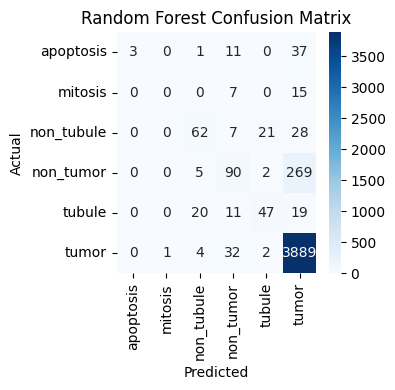

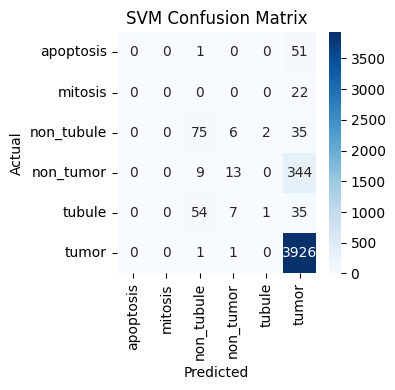

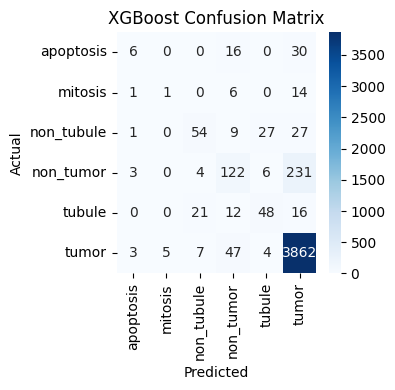

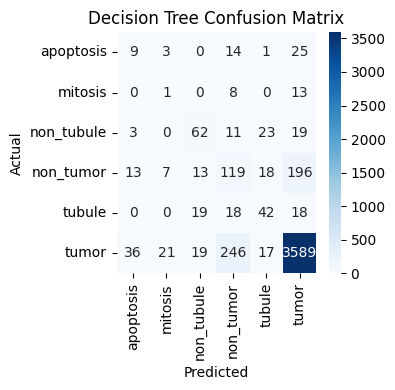

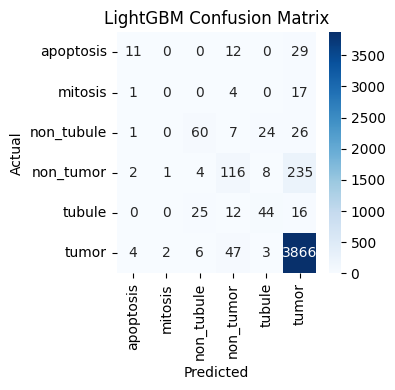

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Plot all confusion matrices
plot_confusion_matrix(cm_rf,     "Random Forest Confusion Matrix")
plot_confusion_matrix(cm_svm,    "SVM Confusion Matrix")
plot_confusion_matrix(cm_xgb,    "XGBoost Confusion Matrix")
plot_confusion_matrix(cm_dt,     "Decision Tree Confusion Matrix")
plot_confusion_matrix(cm_lgbm,   "LightGBM Confusion Matrix")



In [ ]:
feature_names = [
    "mean", "std", "skewness", "kurtosis",
    "percentile_25", "percentile_50", "percentile_75",
    "edge_mean", "edge_std", "edge_max",
    "hist_entropy", "fourier_mean", "fourier_std"
]

def plot_feature_importance_named(importances, model_name):
    feat_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(9, 6))
    sns.barplot(data=feat_df, x="Importance", y="Feature")
    plt.title(f"{model_name} Feature Importance")
    plt.tight_layout()
    plt.show()


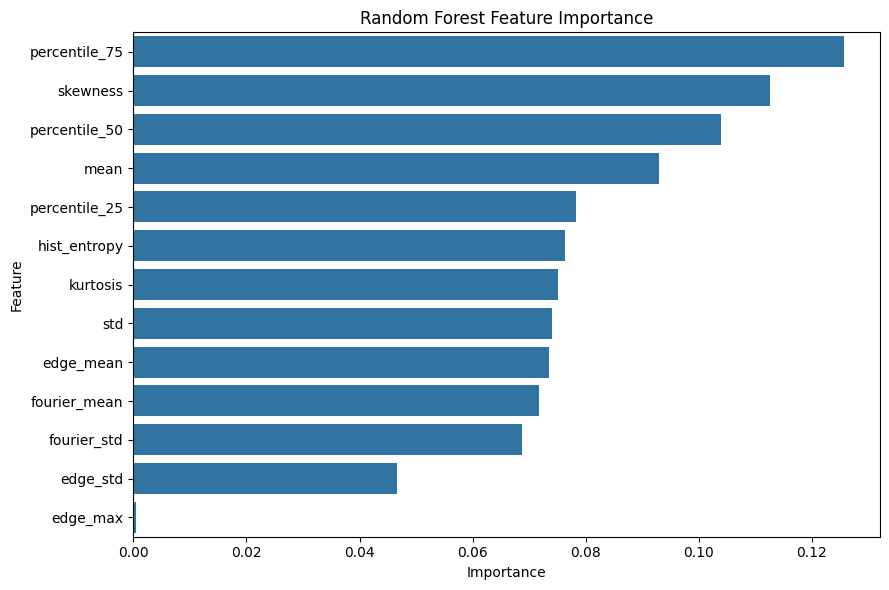

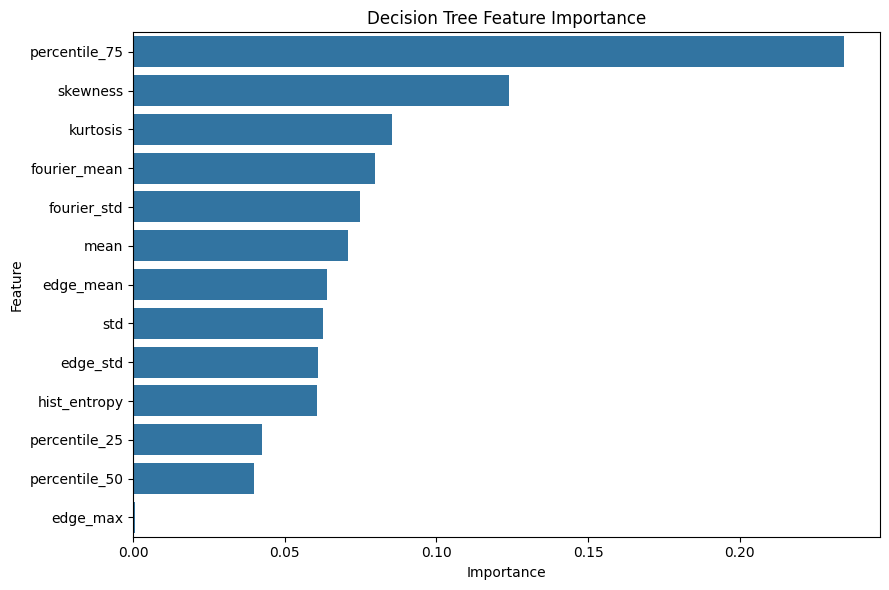

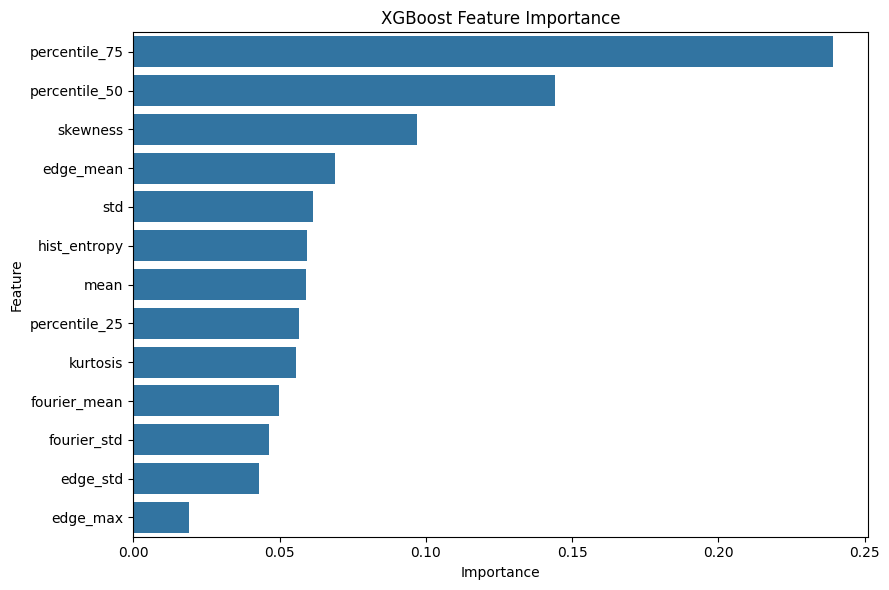

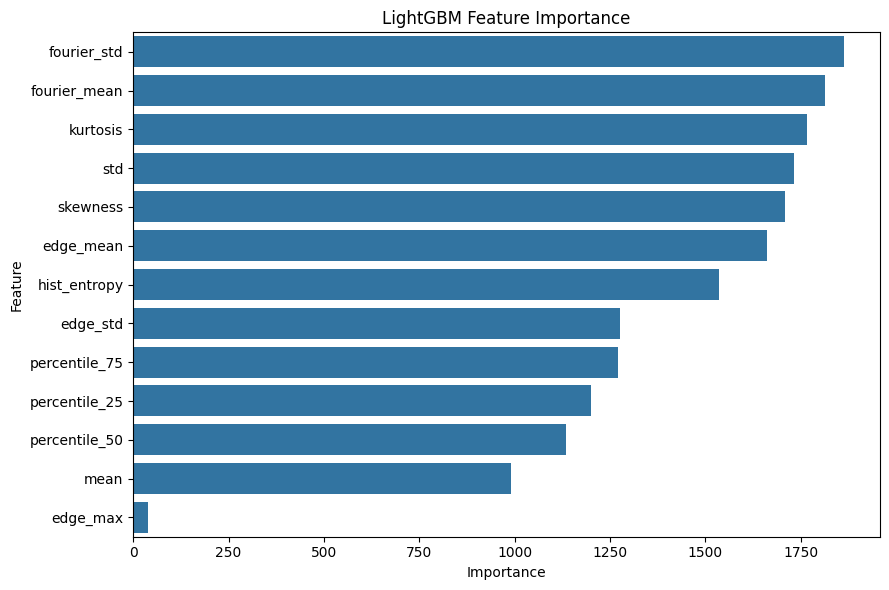

In [ ]:
import pandas as pd

# Plot feature importances for each model
plot_feature_importance_named(rf.feature_importances_, "Random Forest")
plot_feature_importance_named(dt.feature_importances_, "Decision Tree")
plot_feature_importance_named(xgb.feature_importances_, "XGBoost")
plot_feature_importance_named(lgbm.feature_importances_, "LightGBM")


<ipython-input-17-f5dfa282ac94>:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


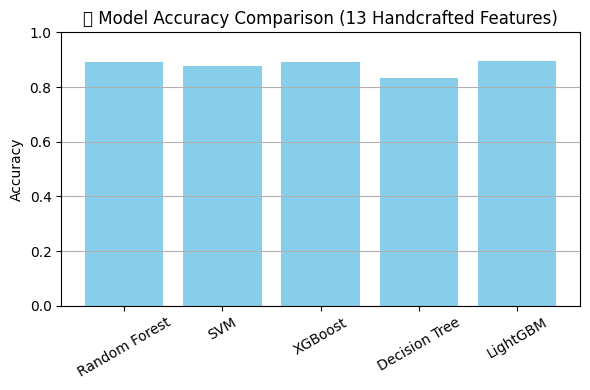

In [ ]:
# Accuracy Recap
models = ['Random Forest', 'SVM', 'XGBoost', 'Decision Tree', 'LightGBM']
accuracies = [acc_rf, acc_svm, acc_xgb, acc_dt, acc_lgbm]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.title("🔍 Model Accuracy Comparison (13 Handcrafted Features)")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Get number of classes
n_classes = len(le.classes_)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))


In [ ]:
def plot_multiclass_roc(y_true_bin, y_prob, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(4, 4))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


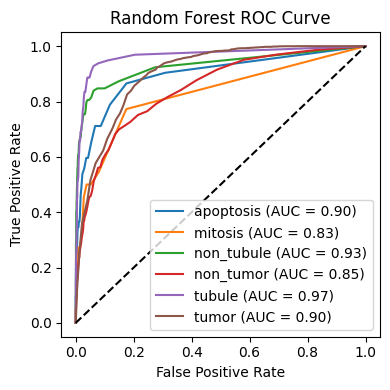

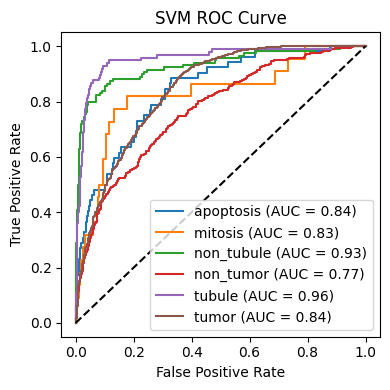

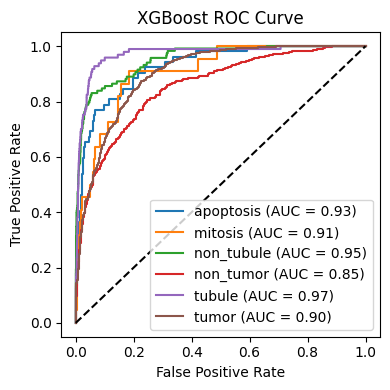

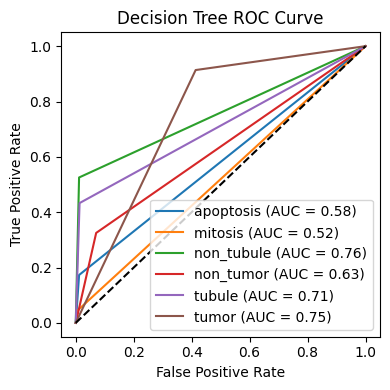

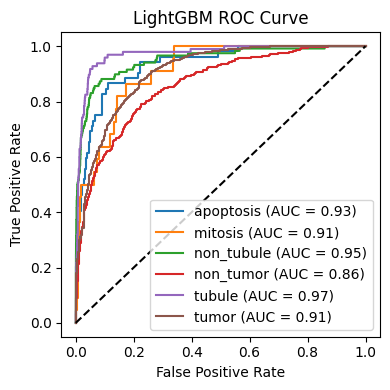

In [ ]:
# Get predicted probabilities
rf_probs   = rf.predict_proba(X_test)
svm_probs  = svm.predict_proba(X_test)
xgb_probs  = xgb.predict_proba(X_test)
dt_probs   = dt.predict_proba(X_test)
lgbm_probs = lgbm.predict_proba(X_test)

# Plot ROC curves
plot_multiclass_roc(y_test_bin, rf_probs, "Random Forest")
plot_multiclass_roc(y_test_bin, svm_probs, "SVM")
plot_multiclass_roc(y_test_bin, xgb_probs, "XGBoost")
plot_multiclass_roc(y_test_bin, dt_probs, "Decision Tree")
plot_multiclass_roc(y_test_bin, lgbm_probs, "LightGBM")


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from collections import Counter
print("🎯 Class distribution after SMOTE:", Counter(y_train_resampled))


🎯 Class distribution after SMOTE: Counter({np.int64(5): 15710, np.int64(3): 15710, np.int64(2): 15710, np.int64(4): 15710, np.int64(0): 15710, np.int64(1): 15710})


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

# Retrain classifiers on balanced data
rf_sm = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sm.fit(X_train_resampled, y_train_resampled)

svm_sm = SVC(kernel='rbf', probability=True, random_state=42)
svm_sm.fit(X_train_resampled, y_train_resampled)

xgb_sm = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_sm.fit(X_train_resampled, y_train_resampled)

lgbm_sm = LGBMClassifier(random_state=42)
lgbm_sm.fit(X_train_resampled, y_train_resampled)

dt_sm = DecisionTreeClassifier(random_state=42)
dt_sm.fit(X_train_resampled, y_train_resampled)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 94260, number of used features: 13
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


DecisionTreeClassifier(random_state=42)

In [ ]:
# Predict on original test set
rf_preds_sm   = rf_sm.predict(X_test)
xgb_preds_sm  = xgb_sm.predict(X_test)
lgbm_preds_sm = lgbm_sm.predict(X_test)
dt_preds_sm   = dt_sm.predict(X_test)

# Evaluate function (already defined earlier)
evaluate_model("Random Forest (SMOTE)", y_test, rf_preds_sm)
evaluate_model("XGBoost (SMOTE)", y_test, xgb_preds_sm)
evaluate_model("LightGBM (SMOTE)", y_test, lgbm_preds_sm)
evaluate_model("Decision Tree (SMOTE)", y_test, dt_preds_sm)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📊 Random Forest (SMOTE) Classification Report:
              precision    recall  f1-score   support

   apoptosis       0.24      0.31      0.27        52
     mitosis       0.10      0.18      0.13        22
  non_tubule       0.50      0.51      0.50       118
   non_tumor       0.41      0.44      0.43       366
      tubule       0.46      0.52      0.49        97
       tumor       0.95      0.93      0.94      3928

    accuracy                           0.86      4583
   macro avg       0.44      0.48      0.46      4583
weighted avg       0.87      0.86      0.86      4583


Random Forest (SMOTE) Confusion Matrix:
[[  16    3    0   15    1   17]
 [   2    4    0    6    0   10]
 [   3    0   60   10   29   16]
 [  13    9   13  161   12  158]
 [   2    0   27    8   50   10]
 [  31   25   20  188   16 3648]]

📊 XGBoost (SMOTE) Classification Report:
              precision    recall  f1-score   support

   apoptosis       0.20      0.38      0.27        52
     mitosis      

array([[  15,    3,    2,   10,    1,   21],
       [   6,    3,    0,    5,    1,    7],
       [   0,    1,   58,    8,   36,   15],
       [  31,   10,   20,  137,   20,  148],
       [   1,    1,   29,   12,   47,    7],
       [  85,   55,   75,  483,   58, 3172]])

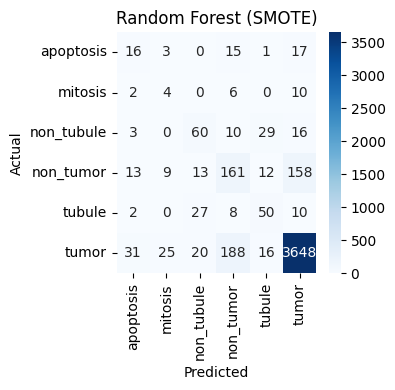

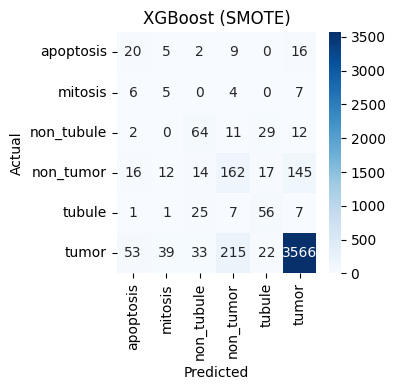

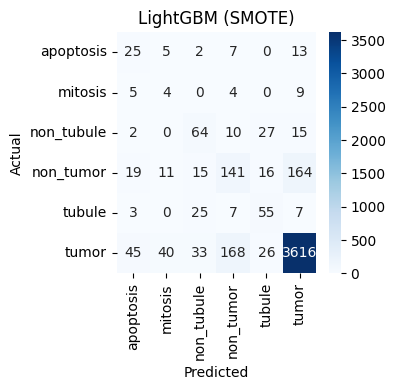

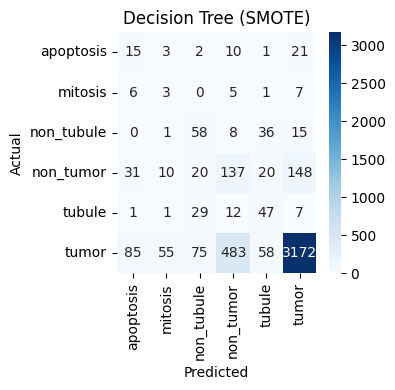

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Generate confusion matrices
cm_rf_sm   = confusion_matrix(y_test, rf_preds_sm)
cm_xgb_sm  = confusion_matrix(y_test, xgb_preds_sm)
cm_lgbm_sm = confusion_matrix(y_test, lgbm_preds_sm)
cm_dt_sm   = confusion_matrix(y_test, dt_preds_sm)

# Plot them
plot_confusion_matrix(cm_rf_sm,   "Random Forest (SMOTE)")
plot_confusion_matrix(cm_xgb_sm,  "XGBoost (SMOTE)")
plot_confusion_matrix(cm_lgbm_sm, "LightGBM (SMOTE)")
plot_confusion_matrix(cm_dt_sm,   "Decision Tree (SMOTE)")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


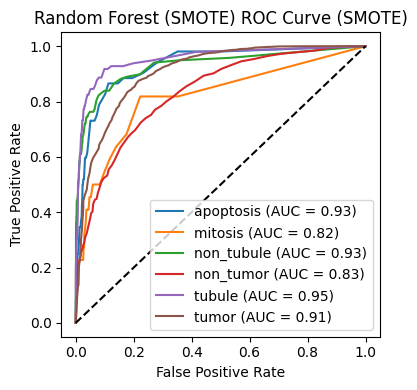

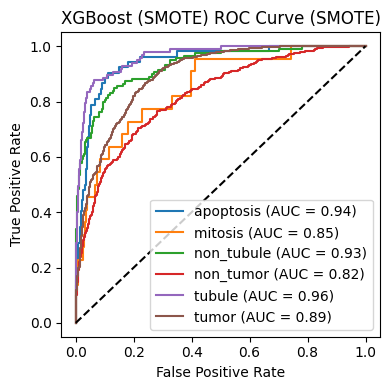

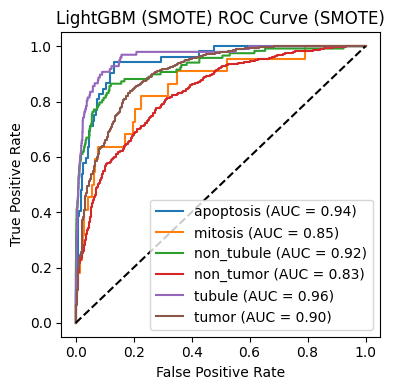

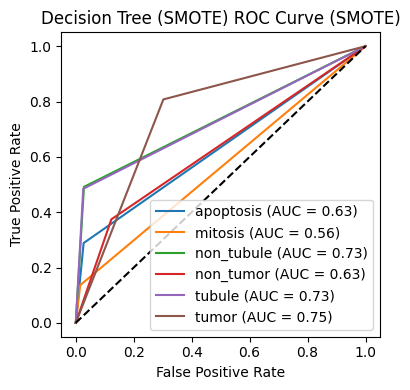

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

# Get predicted probabilities
rf_probs_sm   = rf_sm.predict_proba(X_test)
xgb_probs_sm  = xgb_sm.predict_proba(X_test)
lgbm_probs_sm = lgbm_sm.predict_proba(X_test)
dt_probs_sm   = dt_sm.predict_proba(X_test)

# Plotting function
def plot_multiclass_roc(y_true_bin, y_score, model_name):
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(y_true_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(4, 4))
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} ROC Curve (SMOTE)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot ROC curves
plot_multiclass_roc(y_test_bin, rf_probs_sm,   "Random Forest (SMOTE)")
plot_multiclass_roc(y_test_bin, xgb_probs_sm,  "XGBoost (SMOTE)")
plot_multiclass_roc(y_test_bin, lgbm_probs_sm, "LightGBM (SMOTE)")
plot_multiclass_roc(y_test_bin, dt_probs_sm,   "Decision Tree (SMOTE)")


<ipython-input-26-d9bc59affa96>:32: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


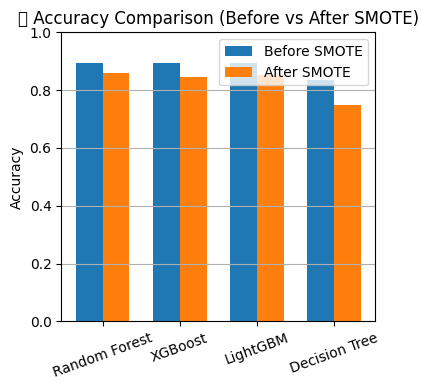

In [ ]:
from sklearn.metrics import accuracy_score

# Before SMOTE
acc_rf  = accuracy_score(y_test, rf_preds)
acc_xgb = accuracy_score(y_test, xgb_preds)
acc_lgbm = accuracy_score(y_test, lgbm_preds)
acc_dt  = accuracy_score(y_test, dt_preds)

# After SMOTE
acc_rf_sm  = accuracy_score(y_test, rf_preds_sm)
acc_xgb_sm = accuracy_score(y_test, xgb_preds_sm)
acc_lgbm_sm = accuracy_score(y_test, lgbm_preds_sm)
acc_dt_sm  = accuracy_score(y_test, dt_preds_sm)

# Bar chart
labels = ['Random Forest', 'XGBoost', 'LightGBM', 'Decision Tree']
before = [acc_rf, acc_xgb, acc_lgbm, acc_dt]
after  = [acc_rf_sm, acc_xgb_sm, acc_lgbm_sm, acc_dt_sm]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(4, 4))
plt.bar(x - width/2, before, width, label='Before SMOTE')
plt.bar(x + width/2, after, width, label='After SMOTE')
plt.ylabel('Accuracy')
plt.title('🔍 Accuracy Comparison (Before vs After SMOTE)')
plt.xticks(x, labels, rotation=20)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("📋 RANDOM FOREST")
print("Before SMOTE:")
print(classification_report(y_test, rf_preds, target_names=le.classes_))
print("After SMOTE:")
print(classification_report(y_test, rf_preds_sm, target_names=le.classes_))

print("\n📋 XGBOOST")
print("Before SMOTE:")
print(classification_report(y_test, xgb_preds, target_names=le.classes_))
print("After SMOTE:")
print(classification_report(y_test, xgb_preds_sm, target_names=le.classes_))

print("\n📋 LIGHTGBM")
print("Before SMOTE:")
print(classification_report(y_test, lgbm_preds, target_names=le.classes_))
print("After SMOTE:")
print(classification_report(y_test, lgbm_preds_sm, target_names=le.classes_))

print("\n📋 DECISION TREE")
print("Before SMOTE:")
print(classification_report(y_test, dt_preds, target_names=le.classes_))
print("After SMOTE:")
print(classification_report(y_test, dt_preds_sm, target_names=le.classes_))


📋 RANDOM FOREST
Before SMOTE:
              precision    recall  f1-score   support

   apoptosis       1.00      0.06      0.11        52
     mitosis       0.00      0.00      0.00        22
  non_tubule       0.67      0.53      0.59       118
   non_tumor       0.57      0.25      0.34       366
      tubule       0.65      0.48      0.56        97
       tumor       0.91      0.99      0.95      3928

    accuracy                           0.89      4583
   macro avg       0.63      0.38      0.42      4583
weighted avg       0.87      0.89      0.87      4583

After SMOTE:
              precision    recall  f1-score   support

   apoptosis       0.24      0.31      0.27        52
     mitosis       0.10      0.18      0.13        22
  non_tubule       0.50      0.51      0.50       118
   non_tumor       0.41      0.44      0.43       366
      tubule       0.46      0.52      0.49        97
       tumor       0.95      0.93      0.94      3928

    accuracy                      

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import cv2

# 1. Define transform for ResNet input
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])   # ImageNet stds
])

# 2. Custom dataset
class PatchDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx]
        if len(img.shape) == 2:  # grayscale → RGB
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = transform(img)
        return img

# 3. Load pretrained ResNet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC
resnet.to(device)
resnet.eval()

# 4. Prepare DataLoader
patch_dataset = PatchDataset(all_patches)
patch_loader = DataLoader(patch_dataset, batch_size=64, shuffle=False)

# 5. Extract features
cnn_features = []

with torch.no_grad():
    for batch in tqdm(patch_loader, desc="🔍 Extracting CNN features"):
        batch = batch.to(device)
        feats = resnet(batch).squeeze(-1).squeeze(-1)  # shape [B, 512]
        cnn_features.append(feats.cpu().numpy())

# 6. Convert to numpy array
cnn_features = np.concatenate(cnn_features, axis=0)
print("✅ CNN feature matrix shape:", cnn_features.shape)  # [N, 512]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]
🔍 Extracting CNN features: 100%|██████████| 359/359 [01:07<00:00,  5.31it/s]

✅ CNN feature matrix shape: (22914, 512)


In [ ]:
# === Recompute handcrafted features if not already in memory ===
def extract_features_extended(img):
    from scipy.stats import kurtosis, skew, entropy
    from scipy.ndimage import sobel

    features = []
    features.append(np.mean(img))                 # mean
    features.append(np.std(img))                  # std
    features.append(skew(img.flatten()))          # skewness
    features.append(kurtosis(img.flatten()))      # kurtosis
    features += list(np.percentile(img, [25, 50, 75]))  # percentiles

    sobel_x = sobel(img, axis=0)
    sobel_y = sobel(img, axis=1)
    edge_mag = np.sqrt(sobel_x**2 + sobel_y**2)

    features.append(np.mean(edge_mag))            # edge_mean
    features.append(np.std(edge_mag))             # edge_std
    features.append(np.max(edge_mag))             # edge_max

    hist, _ = np.histogram(img, bins=32, range=(0, 255), density=True)
    features.append(entropy(hist + 1e-7))          # hist_entropy

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    features.append(np.mean(magnitude))            # fourier_mean
    features.append(np.std(magnitude))             # fourier_std

    return features

# === Run feature extraction ===
X_handcrafted = np.array([extract_features_extended(patch) for patch in all_patches])
print("✅ Handcrafted feature shape:", X_handcrafted.shape)


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


✅ Handcrafted feature shape: (22914, 13)


In [ ]:
# Make sure both feature arrays exist and align
assert cnn_features.shape[0] == X_handcrafted.shape[0], "Mismatch in number of samples!"

# Concatenate horizontally
combined_features = np.concatenate([X_handcrafted, cnn_features], axis=1)
print("✅ Combined feature shape:", combined_features.shape)  # (22914, 525)


✅ Combined feature shape: (22914, 525)


In [ ]:
import pandas as pd

# Feature column names
handcrafted_cols = [
    "mean", "std", "skewness", "kurtosis", "percentile_25", "percentile_50", "percentile_75",
    "edge_mean", "edge_std", "edge_max", "hist_entropy", "fourier_mean", "fourier_std"
]
cnn_cols = [f"CNN_{i+1}" for i in range(cnn_features.shape[1])]

all_cols = handcrafted_cols + cnn_cols

# Build DataFrame
df_combined = pd.DataFrame(combined_features, columns=all_cols)
df_combined['label'] = all_labels  # Append label column

# Save
df_combined.to_csv("features_combined_with_labels.csv", index=False)
print("✅ Saved to features_combined_with_labels.csv")


✅ Saved to features_combined_with_labels.csv


In [ ]:

# Read the CSV file
df = pd.read_csv('features_combined_with_labels.csv')

# Display the DataFrame
df.head()  # This will show the first 5 rows of the DataFrame


mean        std  skewness  kurtosis  percentile_25  percentile_50  \
0  178.524902  48.860141 -0.724635  0.161573          151.0          182.0   
1  171.990479  37.561092 -0.033732 -0.997403          143.0          169.0   
2  140.826416  36.313884  0.180270 -0.890080          108.0          142.0   
3  151.155762  44.300065  0.098341 -1.157433          111.0          150.0   
4  156.222656  50.044402  0.223646 -1.334599          111.0          148.0   

   percentile_75  edge_mean  edge_std  edge_max  ...   CNN_504   CNN_505  \
0          219.0  10.101562  3.978516   15.8125  ...  0.067760  0.122706   
1          204.0  10.273438  3.972656   15.8125  ...  0.217274  0.000000   
2          168.0  10.257812  3.904297   15.8125  ...  0.102221  0.034031   
3          189.0  10.195312  3.972656   15.8125  ...  0.506722  0.073425   
4          203.0  10.265625  3.888672   15.8125  ...  0.270327  0.000000   

    CNN_506   CNN_507   CNN_508   CNN_509   CNN_510   CNN_511   CNN_512  \
0  1.512193  1.693290  0.065475  0.000000  0.542279  0.606712  0.171496   
1  1.140653  0.311948  0.323129  0.022953  0.689605  0.088600  0.200441   
2  0.997225  0.424000  0.065402  0.035772  0.186015  0.089410  0.047570   
3  2.533024  0.303473  0.117172  0.024085  0.462374  0.437112  0.000000   
4  1.472100  0.931061  0.116104  0.000000  0.420954  0.226766  0.101418   

       label  
0  apoptosis  
1      tumor  
2      tumor  
3      tumor  
4      tumor  

[5 rows x 526 columns]

In [ ]:
# ===== MODIFIED CODE WITH DATA CLEANING =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 1. Load data
df = pd.read_csv('features_combined_with_labels.csv')

# 2. Clean infinite/NaN values
X = df.drop('label', axis=1)
y = df['label']

# Convert inf/-inf to NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Impute missing values (including converted infs)
imputer = SimpleImputer(strategy='mean')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 3. Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 5. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now proceed with model training...

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),

}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\n⚡ Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    }
    print(f"{name} Accuracy: {results[name]['accuracy']:.4f}")


⚡ Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Accuracy: 0.9070

⚡ Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:33:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9300

⚡ Training LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133227
[LightGBM] [Info] Number of data points in the train set: 18331, number of used features: 525
[LightGBM] [Info] Start training from score -4.474015
[LightGBM] [Info] Start training from score -5.327713
[LightGBM] [Info] Start training from score -3.659370
[LightGBM] [Info] Start training from score -2.529472
[LightGBM] [Info] Start training from score -3.850202
[LightGBM] [Info] Start training from score -0.154296


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

LightGBM Accuracy: 0.9271

⚡ Training SVM...
SVM Accuracy: 0.9269


<ipython-input-35-01964e465cc3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.keys()), y=accuracies, palette="viridis")


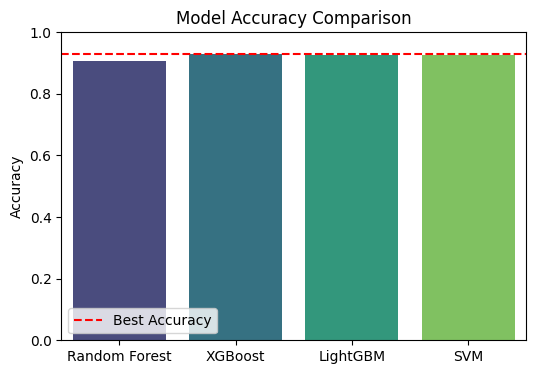


Best Model: XGBoost
              precision    recall  f1-score   support

   apoptosis       0.78      0.40      0.53        52
     mitosis       1.00      0.18      0.31        22
  non_tubule       0.75      0.58      0.65       118
   non_tumor       0.80      0.56      0.66       366
      tubule       0.76      0.60      0.67        97
       tumor       0.95      0.99      0.97      3928

    accuracy                           0.93      4583
   macro avg       0.84      0.55      0.63      4583
weighted avg       0.92      0.93      0.92      4583



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot accuracy comparison
plt.figure(figsize=(6, 4))
accuracies = [results[model]["accuracy"] for model in models]
sns.barplot(x=list(models.keys()), y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.axhline(max(accuracies), color='red', linestyle='--', label="Best Accuracy")
plt.legend()
plt.show()

# Print detailed report for the best model
best_model = max(results, key=lambda x: results[x]["accuracy"])
print(f"\nBest Model: {best_model}")
print(classification_report(y_test, models[best_model].predict(X_test_scaled), target_names=le.classes_))

<ipython-input-36-efac539e5d62>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")
<ipython-input-36-efac539e5d62>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")
<ipython-input-36-efac539e5d62>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")


⚠️ SVM doesn't support feature importance calculation


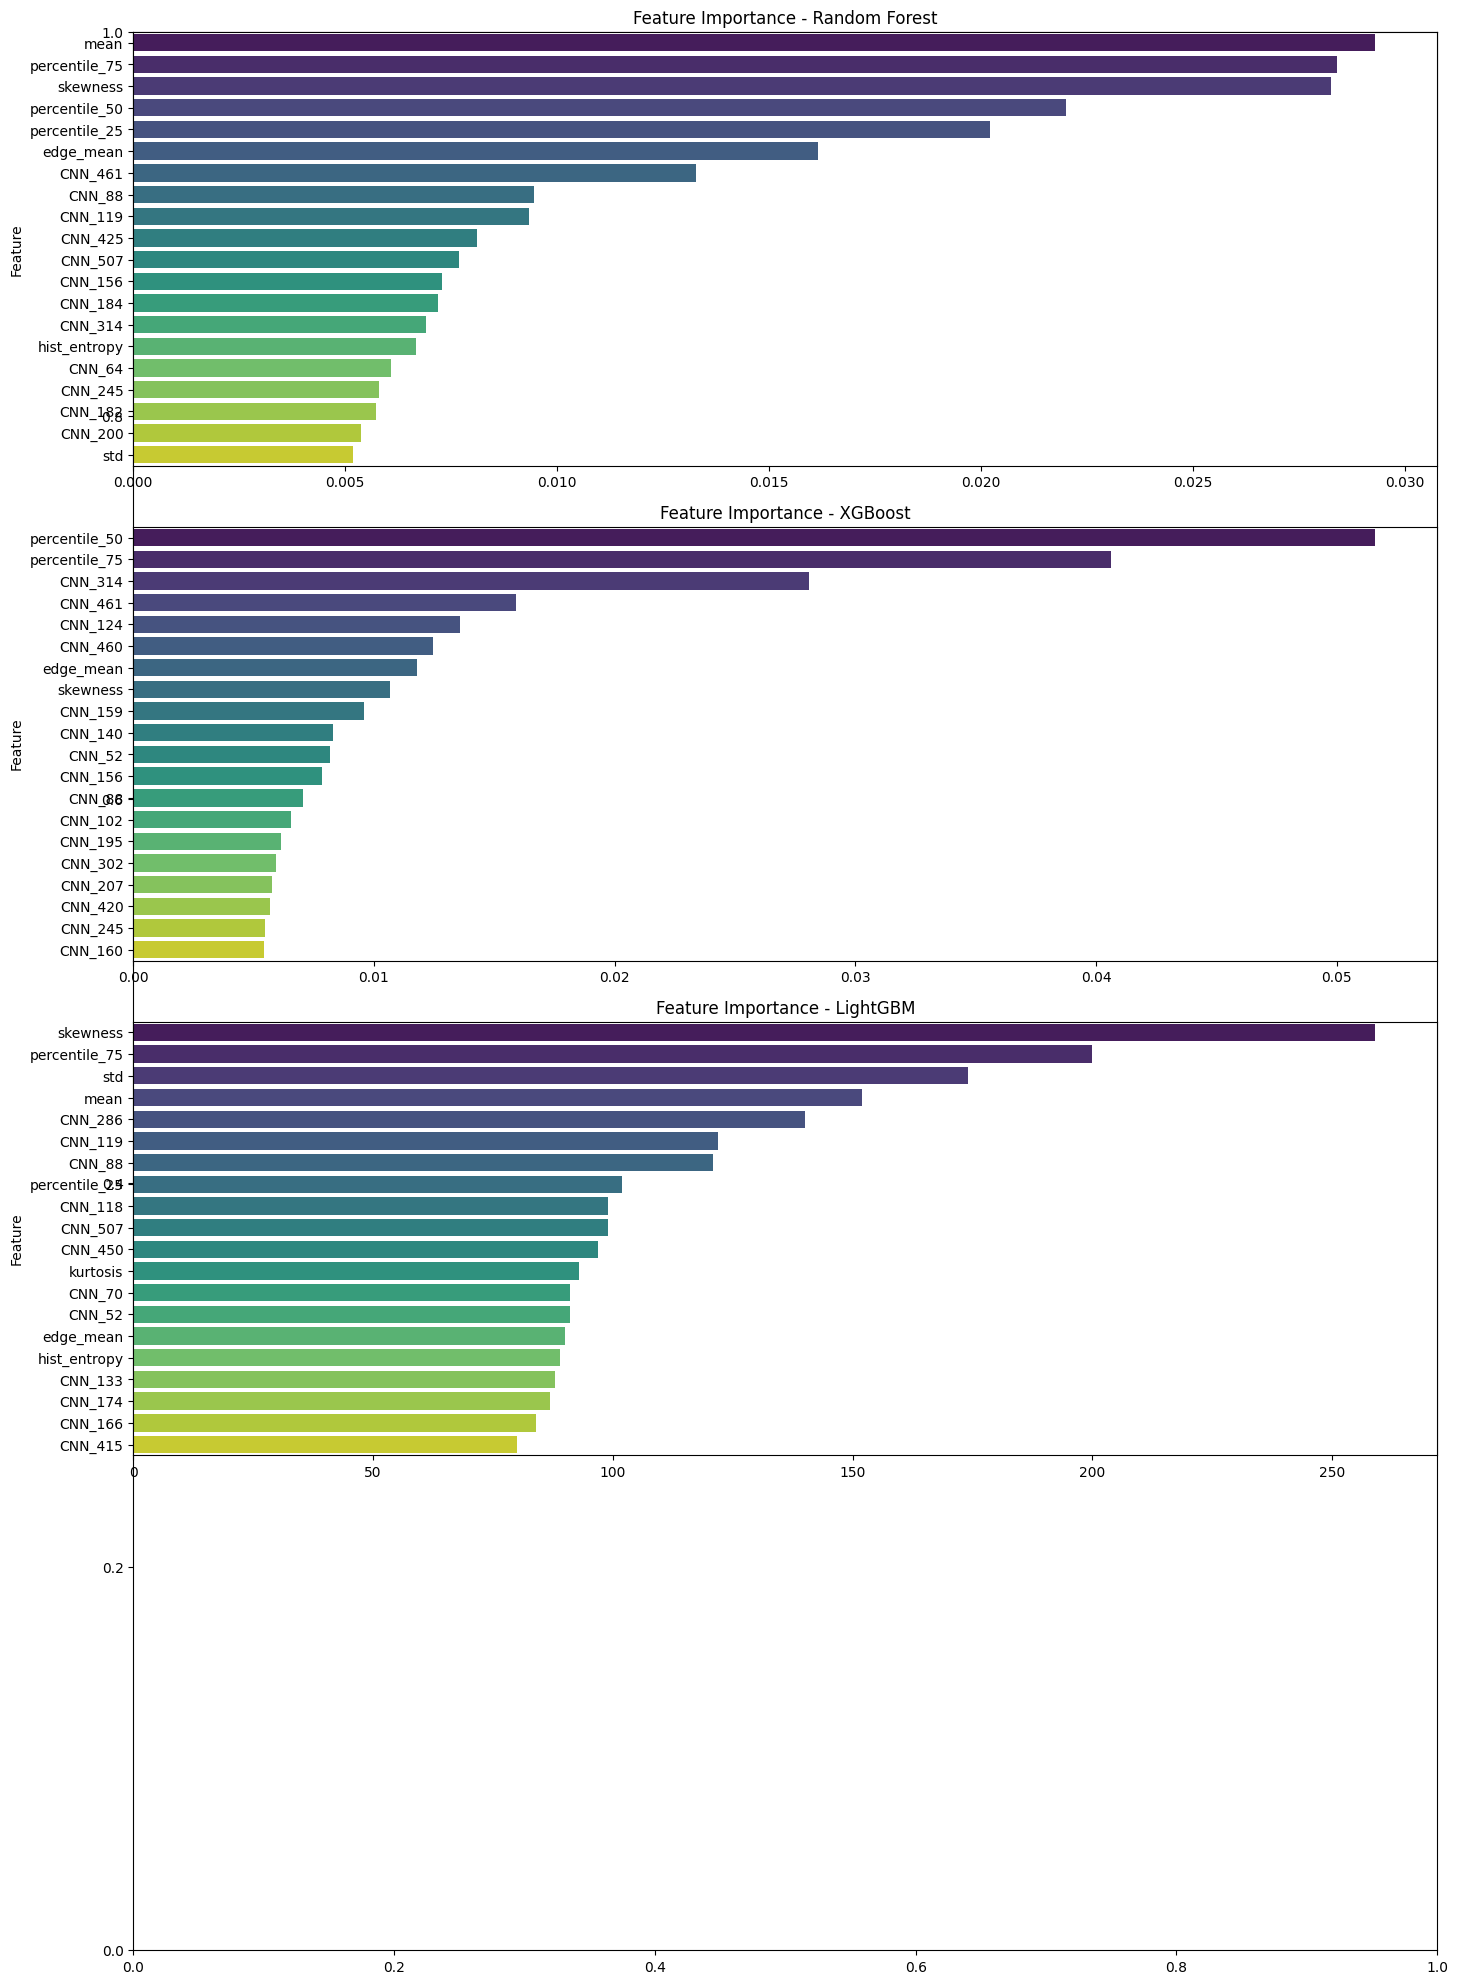

In [ ]:
# ========== Modified Code for All Models ==========
def plot_feature_importance_all(models, X_columns):
    """Plot feature importance for all tree-based models"""
    plt.figure(figsize=(15, 20))

    # Create subplots grid
    axes = plt.subplot(len(models), 1, (1, len(models)))

    for i, (name, model) in enumerate(models.items(), 1):
        # Skip non-tree models
        if not hasattr(model, 'feature_importances_'):
            print(f"⚠️ {name} doesn't support feature importance calculation")
            continue

        # Get importance values
        importances = model.feature_importances_

        # Create DataFrame
        feat_df = pd.DataFrame({
            "Feature": X_columns,
            "Importance": importances
        }).sort_values("Importance", ascending=False).head(20)

        # Create subplot
        plt.subplot(len(models), 1, i)
        sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")
        plt.title(f"Feature Importance - {name}", fontsize=12)
        plt.xlabel("")

    plt.tight_layout()
    plt.show()

# ========== For SVM (Alternative Approach) ==========
def plot_svm_coefficients(svm_model, X_columns, top_n=20):
    """Plot SVM coefficients (only works for linear kernel)"""
    if svm_model.kernel != 'linear':
        print("❌ SVM feature weights only meaningful for linear kernels")
        return

    coef = np.mean(np.abs(svm_model.coef_), axis=0)
    feat_df = pd.DataFrame({
        "Feature": X_columns,
        "Coefficient": coef
    }).sort_values("Coefficient", ascending=False).head(top_n)

    plt.figure(figsize=(6, 3))
    sns.barplot(x="Coefficient", y="Feature", data=feat_df, palette="rocket")
    plt.title("SVM Feature Magnitudes (Linear Kernel)")
    plt.show()

# ========== Usage ==========
# After model training (using your existing code):
plot_feature_importance_all(models, X.columns)

# For SVM (if using linear kernel):
# plot_svm_coefficients(models["SVM"], X.columns)

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_features(image_path, annotation_path):
    # Load image with error handling
    img = cv2.imread(str(image_path))  # Convert Path object to string
    if img is None:
        print(f"❌ Error loading image: {image_path}")
        print("Possible reasons:")
        print("- File doesn't exist")
        print("- Invalid image format (try converting to PNG/JPEG)")
        print("- OpenCV doesn't support TIFF in this environment")
        return

    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"❌ Color conversion error: {e}")
        print("Trying grayscale visualization...")
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Load annotations
    try:
        with open(annotation_path) as f:
            anns = json.load(f)
    except FileNotFoundError:
        print(f"❌ Annotation file not found: {annotation_path}")
        return

    # Rest of visualization code...
    print("✅ Successfully loaded image and annotations!")
    print(f"Image shape: {img.shape}")
    print(f"Annotations: {list(anns.keys())}")

# Test with path validation
image_path = Path("images/Case_1-01.tif")
annotation_path = Path("groundTruth/Case_1-01.json")

if not image_path.exists():
    print(f"🚨 Image path does not exist: {image_path.absolute()}")

if not annotation_path.exists():
    print(f"🚨 Annotation path does not exist: {annotation_path.absolute()}")

if image_path.exists() and annotation_path.exists():
    visualize_features(image_path, annotation_path)
else:
    print("\n🔧 Troubleshooting Tips:")
    print("1. Check file paths in your Colab environment")
    print("2. Verify TIFF support: !apt install libtiff5")
    print("3. Try converting TIFF to PNG:")
    print("   from PIL import Image")
    print("   Image.open('images/Case_1-01.tiff').save('images/Case_1-01.png')")

✅ Successfully loaded image and annotations!
Image shape: (1024, 1360, 3)
Annotations: ['mitosis', 'non_mitosis', 'apoptosis', 'tumor', 'non_tumor', 'lumen', 'non_lumen']


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Initialize GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def load_cnn_model():
    return ResNet50(weights='imagenet', include_top=False)

def get_cnn_activation(img, model):
    # Convert to 3 channels if grayscale
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)

    img_resized = cv2.resize(img, (224, 224))
    img_preprocessed = preprocess_input(img_resized.astype('float32'))

    activation_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[-2].output
    )

    return activation_model.predict(img_preprocessed[np.newaxis, ...])[0, :, :, 0]

def generate_feature_maps(img):
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 1. Edge detection (Sobel)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edge_mag = np.sqrt(sobelx**2 + sobely**2)

    # Normalize edge magnitude
    edge_vis = (edge_mag / edge_mag.max() * 255).astype(np.uint8)
    edge_rgb = cv2.cvtColor(edge_vis, cv2.COLOR_GRAY2RGB)

    # 2. Intensity threshold
    p75 = np.percentile(gray, 75)
    _, thresh = cv2.threshold(gray, p75, 255, cv2.THRESH_BINARY)
    thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

    # 3. Fourier transform
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1e-5)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # CNN activation
    model = load_cnn_model()
    activation = get_cnn_activation(img, model)
    activation = cv2.resize(activation, (img.shape[1], img.shape[0]))
    activation = (activation - activation.min()) / (activation.max() - activation.min())
    cnn_rgb = cv2.applyColorMap((activation * 255).astype(np.uint8), cv2.COLORMAP_VIRIDIS)

    # 5. Combined overlay
    overlay = cv2.addWeighted(img, 0.7, edge_rgb, 0.3, 0)

    return [edge_rgb, thresh_rgb, magnitude, cnn_rgb, overlay]

# Rest of the code remains the same
def visualize_annotations_and_features(img, annotations, feature_maps):
    """Visualize original image with annotations and feature maps"""
    # ... [rest of this function remains unchanged] ...

# ===== MAIN EXECUTION =====
if __name__ == "__main__":
    # Load data
    with open("groundTruth/Case_1-01.json") as f:
        annotations = json.load(f)

    # Load image
    img = cv2.cvtColor(cv2.imread("images/Case_1-01.tif"), cv2.COLOR_BGR2RGB)

    # Generate features
    feature_maps = generate_feature_maps(img)

    # Visualize
    visualize_annotations_and_features(img, annotations, feature_maps)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


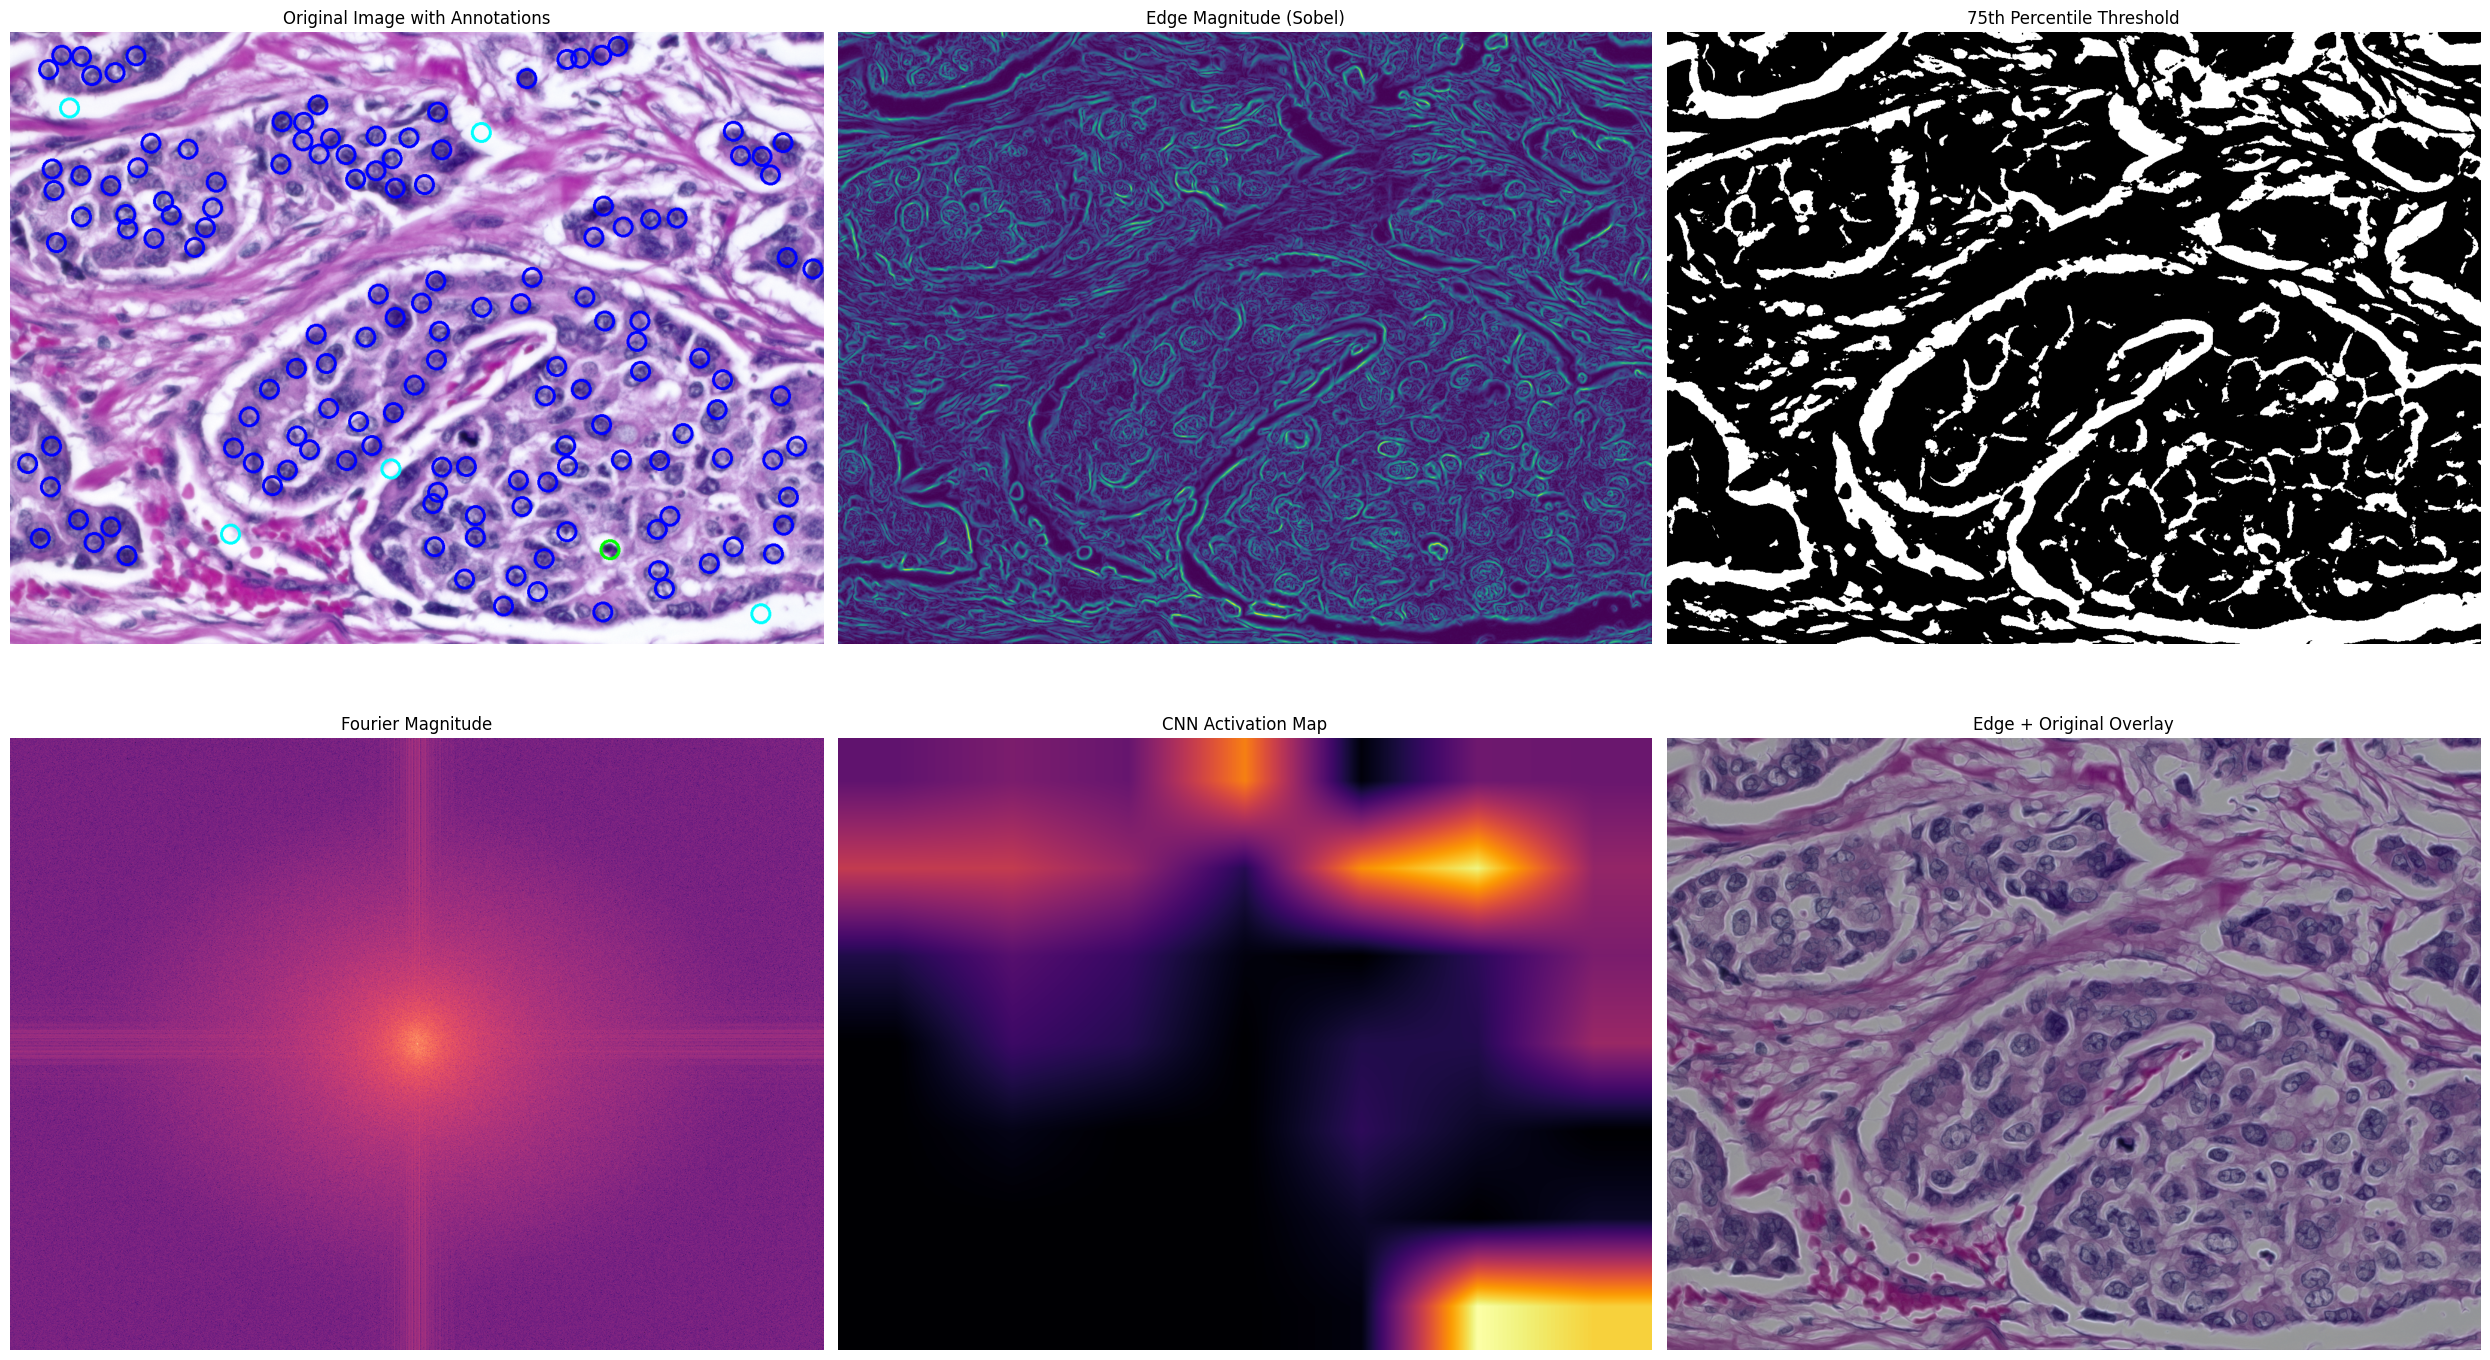

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Initialize GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load CNN model once
model = ResNet50(weights='imagenet', include_top=False)
model.trainable = False  # Freeze model

def get_cnn_activation(img):
    """Extract CNN activation map for visualization"""
    # Convert to 3-channel if needed
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Preprocess for ResNet
    img_resized = cv2.resize(img, (224, 224))
    img_preprocessed = preprocess_input(img_resized.astype('float32'))

    # Get activations from last conv layer
    activations = model.predict(img_preprocessed[np.newaxis, ...], verbose=0)
    return activations[0, :, :, 0]  # First channel of last conv layer

def visualize_features(image_path, annotation_path):
    """Main visualization function"""
    # Load and verify data
    try:
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        with open(annotation_path) as f:
            annotations = json.load(f)
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # Create visualization figure
    plt.figure(figsize=(25, 15))

    # 1. Original Image with Annotations
    plt.subplot(2, 3, 1)
    annotated_img = img.copy()
    colors = {
        'mitosis': (255, 0, 0),     # Red
        'apoptosis': (0, 255, 0),   # Green
        'tumor': (0, 0, 255),       # Blue
        'non_tumor': (255, 255, 0), # Yellow
        'lumen': (255, 0, 255),     # Magenta
        'non_lumen': (0, 255, 255)  # Cyan
    }

    # Draw annotations
    for label, points in annotations.items():
        if label in colors and points:
            for point in points:
                x = int(point['x'] * img.shape[1])
                y = int(point['y'] * img.shape[0])
                cv2.circle(annotated_img, (x, y), 15, colors[label], 3)

    plt.imshow(annotated_img)
    plt.title("Original Image with Annotations")
    plt.axis('off')

    # 2. Edge Detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edge_mag = np.sqrt(sobelx**2 + sobely**2)
    plt.subplot(2, 3, 2)
    plt.imshow(edge_mag, cmap='viridis')
    plt.title("Edge Magnitude (Sobel)")
    plt.axis('off')

    # 3. Intensity Threshold
    p75 = np.percentile(gray, 75)
    _, thresh = cv2.threshold(gray, p75, 255, cv2.THRESH_BINARY)
    plt.subplot(2, 3, 3)
    plt.imshow(thresh, cmap='gray')
    plt.title("75th Percentile Threshold")
    plt.axis('off')

    # 4. Fourier Transform
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1e-5)
    plt.subplot(2, 3, 4)
    plt.imshow(magnitude, cmap='magma')
    plt.title("Fourier Magnitude")
    plt.axis('off')

    # 5. CNN Activation
    cnn_activation = get_cnn_activation(img)
    cnn_activation = cv2.resize(cnn_activation, (img.shape[1], img.shape[0]))
    plt.subplot(2, 3, 5)
    plt.imshow(cnn_activation, cmap='inferno')
    plt.title("CNN Activation Map")
    plt.axis('off')

    # 6. Feature Overlay
    overlay = cv2.addWeighted(
        img, 0.6,
        cv2.cvtColor((edge_mag/edge_mag.max()*255).astype(np.uint8), cv2.COLOR_GRAY2RGB),
        0.4, 0
    )


    plt.subplot(2, 3, 6)
    plt.imshow(overlay)
    plt.title("Edge + Original Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_features(
    image_path="images/Case_1-01.tif",
    annotation_path="groundTruth/Case_1-01.json"
)

<Figure size 600x600 with 0 Axes>

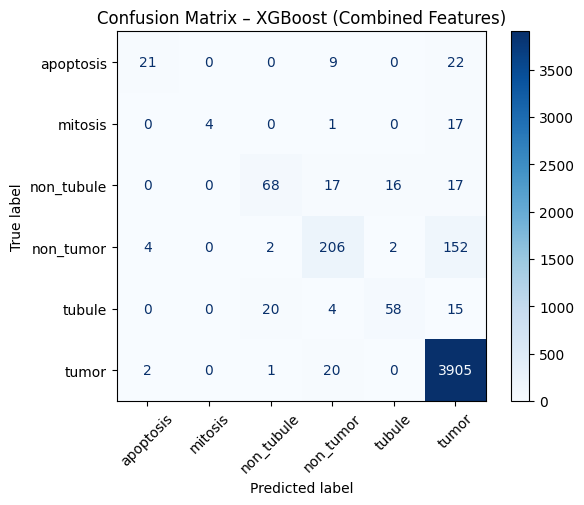

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred_xgb = models["XGBoost"].predict(X_test_scaled)

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – XGBoost (Combined Features)")
plt.grid(False)
plt.show()


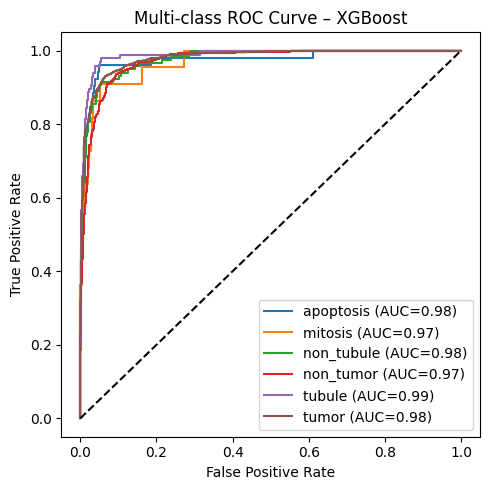

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Get probabilities and binarized labels
xgb_probs = models["XGBoost"].predict_proba(X_test_scaled)
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

# Plot ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], xgb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(5, 5))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve – XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Get feature importance
importances = models["XGBoost"].feature_importances_
features = X.columns  # from the combined dataframe

# Top-k features
feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_k = 30
feat_df.head(top_k).to_csv("top_30_features_xgboost.csv", index=False)
print("✅ Top 30 features saved to CSV.")


✅ Top 30 features saved to CSV.


In [ ]:
import pandas as pd
df = pd.read_csv('top_30_features_xgboost.csv')
df.head()

Feature  Importance
0  percentile_50    0.051594
1  percentile_75    0.040619
2        CNN_314    0.028089
3        CNN_461    0.015906
4        CNN_124    0.013572

In [ ]:
# Load top 30 features
top_features = pd.read_csv("top_30_features_xgboost.csv")["Feature"].tolist()

# Subset feature matrices
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# Define models
models_top = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    #"Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# Train and evaluate
results_top = {}
for name, model in models_top.items():
    print(f"\n Retraining {name} on top 30 features...")
    model.fit(X_train_top_scaled, y_train)
    preds = model.predict(X_test_top_scaled)

    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, target_names=le.classes_, output_dict=True)

    results_top[name] = {"accuracy": acc, "report": report}
    print(f"{name} Accuracy (Top-30): {acc:.4f}")



 Retraining XGBoost on top 30 features...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:41:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (Top-30): 0.9210

 Retraining Random Forest on top 30 features...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/u

Random Forest Accuracy (Top-30): 0.9136

 Retraining LightGBM on top 30 features...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7421
[LightGBM] [Info] Number of data points in the train set: 18331, number of used features: 30
[LightGBM] [Info] Start training from score -4.474015
[LightGBM] [Info] Start training from score -5.327713
[LightGBM] [Info] Start training from score -3.659370
[LightGBM] [Info] Start training from score -2.529472
[LightGBM] [Info] Start training from score -3.850202
[LightGBM] [Info] Start training from score -0.154296


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

LightGBM Accuracy (Top-30): 0.9186

 Retraining SVM on top 30 features...
SVM Accuracy (Top-30): 0.9166


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-47-71ccb2a4b973>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


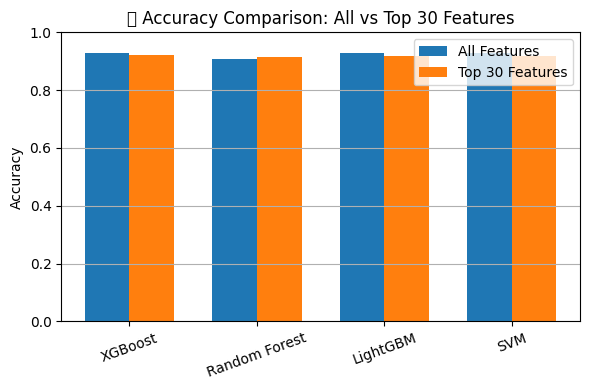

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy comparison
plt.figure(figsize=(6, 4))
before_acc = [results[model]["accuracy"] for model in models_top]
after_acc = [results_top[model]["accuracy"] for model in models_top]
models_list = list(models_top.keys())

x = np.arange(len(models_list))
width = 0.35

plt.bar(x - width/2, before_acc, width, label='All Features')
plt.bar(x + width/2, after_acc, width, label='Top 30 Features')
plt.xticks(x, models_list, rotation=20)
plt.ylabel("Accuracy")
plt.title("📊 Accuracy Comparison: All vs Top 30 Features")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


<Figure size 500x500 with 0 Axes>

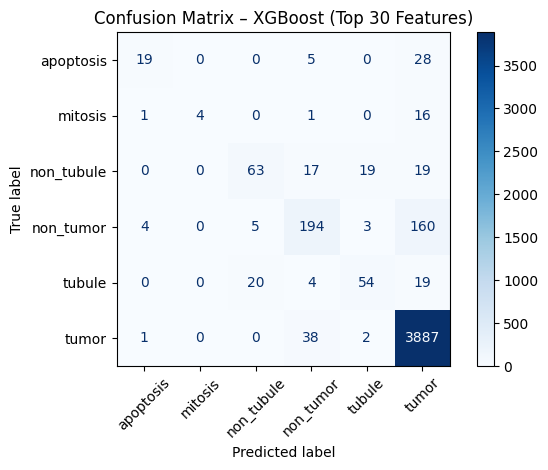

<Figure size 500x500 with 0 Axes>

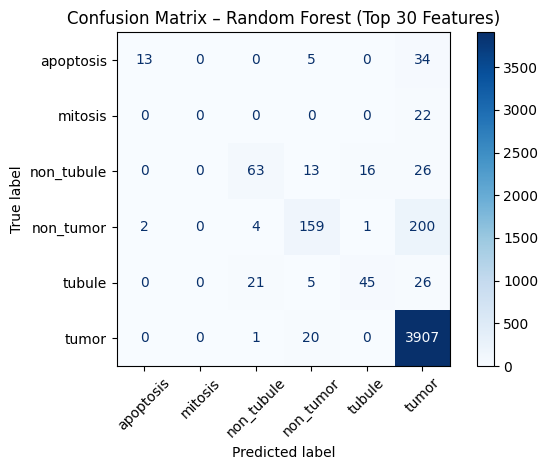

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Figure size 500x500 with 0 Axes>

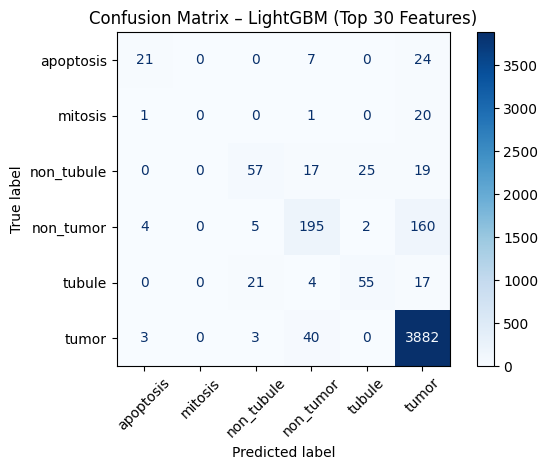

<Figure size 500x500 with 0 Axes>

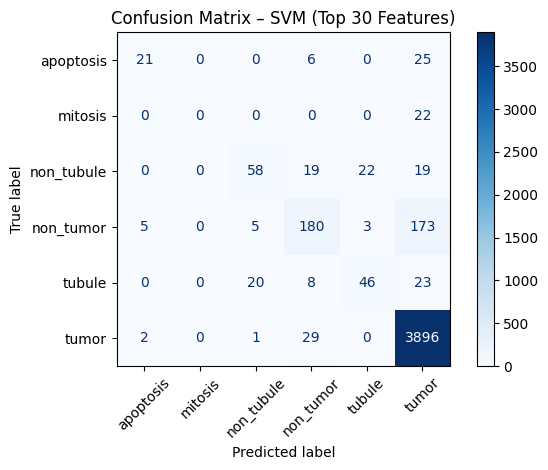

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models_top.items():
    y_pred = model.predict(X_test_top_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix – {name} (Top 30 Features)")
    plt.tight_layout()
    plt.grid(False)
    plt.show()


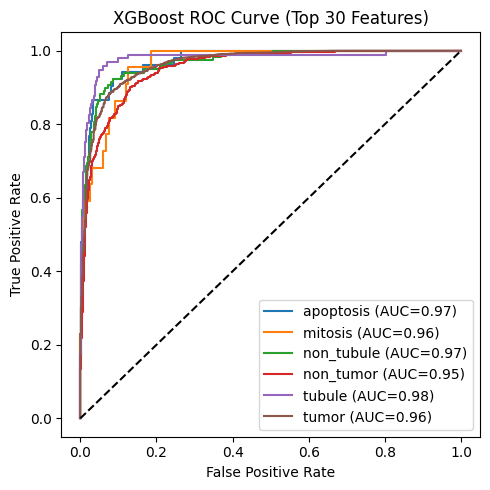

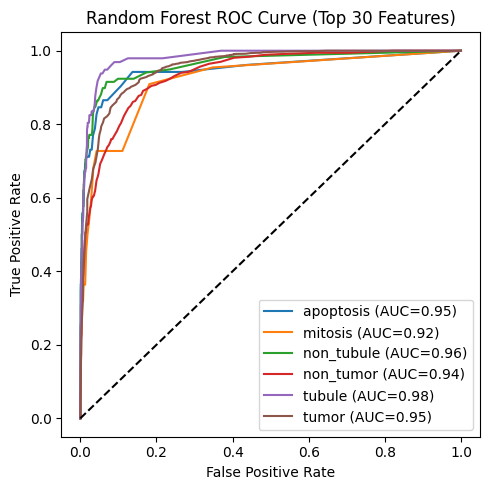

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


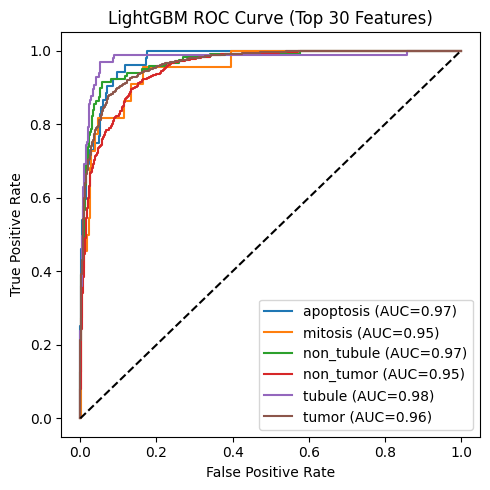

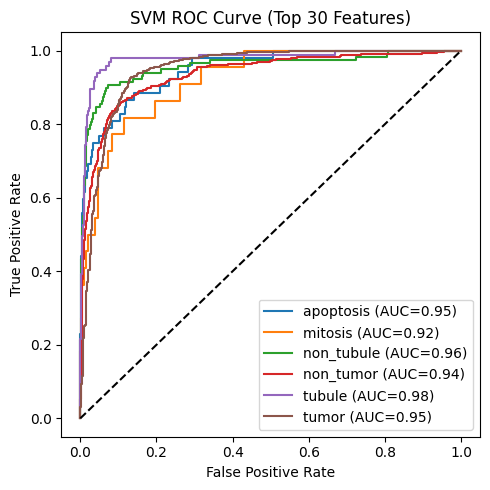

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

def plot_multiclass_roc_top(model, model_name):
    y_prob = model.predict_proba(X_test_top_scaled)
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(5, 5))
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve (Top 30 Features)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Only models with predict_proba
for name in ["XGBoost", "Random Forest", "LightGBM", "SVM"]:
    plot_multiclass_roc_top(models_top[name], name)


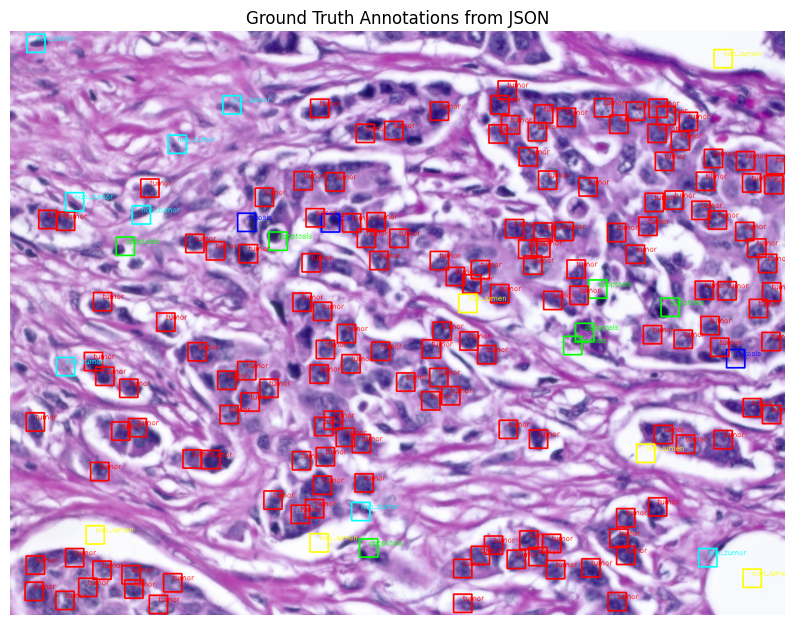

In [ ]:
import cv2
import json
import matplotlib.pyplot as plt

def draw_json_annotations(image_path, annotation_path, box_size=32):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found: {image_path}")
    h, w = image.shape[:2]

    # Load JSON
    with open(annotation_path, 'r') as f:
        annotations = json.load(f)

    # Define colors for each label
    label_colors = {
        'mitosis': (255, 0, 0),
        'apoptosis': (0, 255, 0),
        'tumor': (0, 0, 255),
        'non_tumor': (255, 255, 0),
        'lumen': (255, 0, 255),
        'non_lumen': (0, 255, 255)
    }

    # Draw each annotation
    for label, points in annotations.items():
        color = label_colors.get(label, (255, 255, 255))
        for point in points:
            x = int(point['x'] * w)
            y = int(point['y'] * h)
            cv2.rectangle(image, (x - box_size//2, y - box_size//2), (x + box_size//2, y + box_size//2), color, 2)
            cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    return image

# Example usage:
img_path = "images/Case_1-02.tif"
json_path = "groundTruth/Case_1-02.json"

annotated_image = draw_json_annotations(img_path, json_path)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth Annotations from JSON")
plt.axis('off')
plt.show()
